In [ ]:
!pip install wandb

In [1]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ajay-madkami-iitm (ajay-madkami-iitm-indian-institute-of-technology-mad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

**Question 1** : Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

# Initialize WandB
wandb.init(project="Assignment1")

# Load the dataset
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

# Split training set into training and validation sets
split = int(0.8 * len(X_train))  # 80% for training, 20% for validation
X_validation, Y_validation = X_train[split:], Y_train[split:]
X_train, Y_train = X_train[:split], Y_train[:split]

# Flatten the images
X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_validation = X_validation.reshape(X_validation.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)

# Normalize the data (scale pixel values to [0, 1])
X_train = X_train.astype('float32') / 255.0
X_validation = X_validation.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encoding of labels
Y_train = to_categorical(Y_train, 10)
Y_validation = to_categorical(Y_validation, 10)
Y_test = to_categorical(Y_test, 10)

# Log dataset details to WandB
wandb.config.update({
    "train_size": X_train.shape[0],
    "validation_size": X_validation.shape[0],
    "test_size": X_test.shape[0],
    "image_shape": (28, 28)
})

# Class names in Fashion MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Log sample images to WandB
wandb.log({"sample_images": [wandb.Image(X_train[i].reshape(28, 28), caption=class_names[Y_train[i].argmax()]) for i in range(10)]})

# Print dataset shapes
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_validation shape:", X_validation.shape)
print("Y_validation shape:", Y_validation.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

# Finish WandB run
wandb.finish()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
X_train shape: (48000, 784)
Y_train shape: (48000, 10)
X_validation shape: (12000, 784)
Y_validation shape: (12000, 10)
X_test shape: (10000, 784)
Y_test shape: (10000, 10)


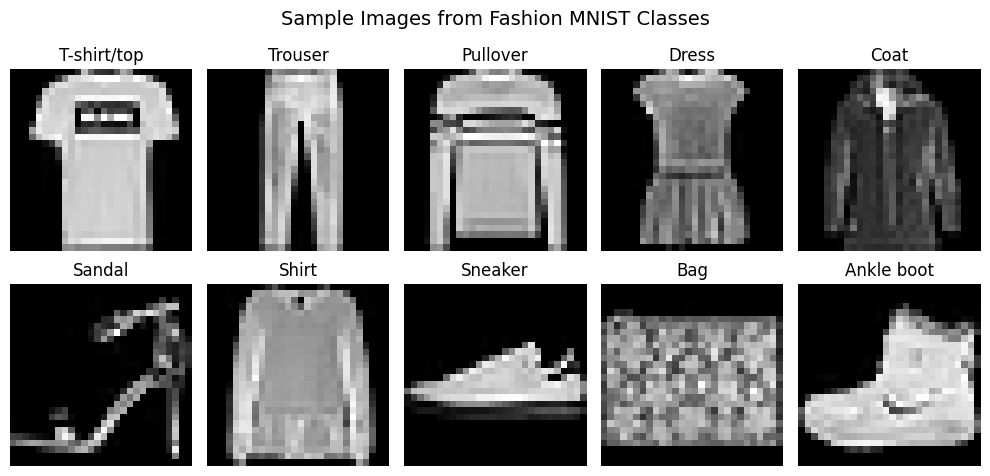

In [ ]:
# Plot sample images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Sample Images from Fashion MNIST Classes", fontsize=14)

for i in range(10):
    ax = axes[i // 5, i % 5]
    idx = np.where(Y_train.argmax(axis=1) == i)[0][0]  # Find an index for each class
    ax.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    ax.set_title(class_names[i])
    ax.axis('off')

plt.tight_layout()
plt.show()  # Ensure images are displayed in the output


**Question 2** : Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.


**Question 3 **:
Implement the backpropagation algorithm with support for the following optimisation functions

**SGD**

In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

def initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size):
    weights = []
    biases = []
    layer_sizes = [input_size] + [num_nodes_hidden_layers] * num_hidden_layers + [output_size]

    for i in range(len(layer_sizes) - 1):
        weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2. / layer_sizes[i]))
        biases.append(np.zeros((1, layer_sizes[i+1])))

    return weights, biases

def apply_optimizer(weights, biases, gradients_w, gradients_b, lr):
    for i in range(len(weights)):
        weights[i] -= lr * gradients_w[i]
        biases[i] -= lr * gradients_b[i]
    return weights, biases

def forward_propagation(X, weights, biases, num_hidden_layers, activation):
    activations = [X]
    for i in range(num_hidden_layers):
        z = np.dot(activations[-1], weights[i]) + biases[i]
        a = np.maximum(0, z) if activation == 'relu' else 1 / (1 + np.exp(-z))
        activations.append(a)

    z_out = np.dot(activations[-1], weights[-1]) + biases[-1]
    exp_scores = np.exp(z_out - np.max(z_out, axis=1, keepdims=True))
    activations.append(exp_scores / np.sum(exp_scores, axis=1, keepdims=True))
    return activations

def backward_propagation(X, Y, weights, biases, activations, num_hidden_layers):
    gradients_w = [None] * len(weights)
    gradients_b = [None] * len(biases)

    delta = activations[-1] - Y
    gradients_w[-1] = np.dot(activations[-2].T, delta) / X.shape[0]
    gradients_b[-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    for i in range(num_hidden_layers, 0, -1):
        delta = np.dot(delta, weights[i].T) * (activations[i] > 0)
        gradients_w[i-1] = np.dot(activations[i-1].T, delta) / X.shape[0]
        gradients_b[i-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    return gradients_w, gradients_b

def cross_entropy_loss(predictions, Y):
    return -np.mean(np.sum(Y * np.log(predictions + 1e-9), axis=1))

def calculate_accuracy(X_test, Y_test, weights, biases, num_hidden_layers, activation):
    activations = forward_propagation(X_test, weights, biases, num_hidden_layers, activation)
    predictions = np.argmax(activations[-1], axis=1)
    actual = np.argmax(Y_test, axis=1)
    return np.mean(predictions == actual) * 100

def sgd_optimizer(lr, X_train, Y_train, X_valid, Y_valid, epochs, activation, num_hidden_layers, num_nodes_hidden_layers, batch_size, input_size, output_size):
    wandb.init(project="Assignment1", name="SGD-training")
    weights, biases = initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size)

    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = Y_train[i:i+batch_size]
            activations = forward_propagation(x_batch, weights, biases, num_hidden_layers, activation)
            gradients_w, gradients_b = backward_propagation(x_batch, y_batch, weights, biases, activations, num_hidden_layers)
            weights, biases = apply_optimizer(weights, biases, gradients_w, gradients_b, lr)

        val_acc = calculate_accuracy(X_valid, Y_valid, weights, biases, num_hidden_layers, activation)
        loss = cross_entropy_loss(activations[-1], y_batch)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        wandb.log({"epoch": epoch + 1, "loss": loss, "validation_accuracy": val_acc})

    wandb.finish()

# Load data and preprocess
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train, X_test = X_train.reshape(-1, 28*28) / 255.0, X_test.reshape(-1, 28*28) / 255.0
Y_train, Y_test = to_categorical(Y_train, 10), to_categorical(Y_test, 10)

# Split train into train and validation sets
split_idx = int(0.8 * X_train.shape[0])
X_valid, Y_valid = X_train[split_idx:], Y_train[split_idx:]
X_train, Y_train = X_train[:split_idx], Y_train[:split_idx]

# Run optimizer function
sgd_optimizer(lr=0.1, X_train=X_train, Y_train=Y_train, X_valid=X_valid, Y_valid=Y_valid,
                   epochs=10, activation='relu', num_hidden_layers=2, num_nodes_hidden_layers=128,
                   batch_size=64, input_size=28*28, output_size=10)


Epoch 1/10, Loss: 0.3164, Validation Accuracy: 84.28%
Epoch 2/10, Loss: 0.2728, Validation Accuracy: 85.71%
Epoch 3/10, Loss: 0.2484, Validation Accuracy: 86.24%
Epoch 4/10, Loss: 0.2505, Validation Accuracy: 86.60%
Epoch 5/10, Loss: 0.2399, Validation Accuracy: 87.04%
Epoch 6/10, Loss: 0.2313, Validation Accuracy: 87.15%
Epoch 7/10, Loss: 0.2243, Validation Accuracy: 87.29%
Epoch 8/10, Loss: 0.2299, Validation Accuracy: 87.43%
Epoch 9/10, Loss: 0.2295, Validation Accuracy: 87.46%
Epoch 10/10, Loss: 0.2158, Validation Accuracy: 87.47%


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▃▃▂▂▂▂▁
validation_accuracy,▁▄▅▆▇▇████
epoch,10
loss,0.21581
validation_accuracy,87.46667


**Momentum based gradient descent**

In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

def initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size):
    weights = []
    biases = []
    layer_sizes = [input_size] + [num_nodes_hidden_layers] * num_hidden_layers + [output_size]

    for i in range(len(layer_sizes) - 1):
        weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2. / layer_sizes[i]))
        biases.append(np.zeros((1, layer_sizes[i+1])))

    return weights, biases

def apply_momentum(weights, biases, gradients_w, gradients_b, lr, velocity_w, velocity_b, momentum=0.9):
    for i in range(len(weights)):
        velocity_w[i] = momentum * velocity_w[i] - lr * gradients_w[i]
        velocity_b[i] = momentum * velocity_b[i] - lr * gradients_b[i]
        weights[i] += velocity_w[i]
        biases[i] += velocity_b[i]
    return weights, biases, velocity_w, velocity_b

def forward_propagation(X, weights, biases, num_hidden_layers, activation):
    activations = [X]
    for i in range(num_hidden_layers):
        z = np.dot(activations[-1], weights[i]) + biases[i]
        a = np.maximum(0, z) if activation == 'relu' else 1 / (1 + np.exp(-z))
        activations.append(a)

    z_out = np.dot(activations[-1], weights[-1]) + biases[-1]
    exp_scores = np.exp(z_out - np.max(z_out, axis=1, keepdims=True))
    activations.append(exp_scores / np.sum(exp_scores, axis=1, keepdims=True))
    return activations

def backward_propagation(X, Y, weights, biases, activations, num_hidden_layers):
    gradients_w = [None] * len(weights)
    gradients_b = [None] * len(biases)

    delta = activations[-1] - Y
    gradients_w[-1] = np.dot(activations[-2].T, delta) / X.shape[0]
    gradients_b[-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    for i in range(num_hidden_layers, 0, -1):
        delta = np.dot(delta, weights[i].T) * (activations[i] > 0)
        gradients_w[i-1] = np.dot(activations[i-1].T, delta) / X.shape[0]
        gradients_b[i-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    return gradients_w, gradients_b

def cross_entropy_loss(predictions, Y):
    return -np.mean(np.sum(Y * np.log(predictions + 1e-9), axis=1))

def calculate_accuracy(X_test, Y_test, weights, biases, num_hidden_layers, activation):
    activations = forward_propagation(X_test, weights, biases, num_hidden_layers, activation)
    predictions = np.argmax(activations[-1], axis=1)
    actual = np.argmax(Y_test, axis=1)
    return np.mean(predictions == actual) * 100

def momentum_optimizer(lr, X_train, Y_train, X_valid, Y_valid, epochs, activation, num_hidden_layers, num_nodes_hidden_layers, batch_size, input_size, output_size, momentum=0.9):
    wandb.init(project="Assignment1", name="Momentum-training")
    weights, biases = initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size)
    velocity_w = [np.zeros_like(w) for w in weights]
    velocity_b = [np.zeros_like(b) for b in biases]

    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = Y_train[i:i+batch_size]
            activations = forward_propagation(x_batch, weights, biases, num_hidden_layers, activation)
            gradients_w, gradients_b = backward_propagation(x_batch, y_batch, weights, biases, activations, num_hidden_layers)
            weights, biases, velocity_w, velocity_b = apply_momentum(weights, biases, gradients_w, gradients_b, lr, velocity_w, velocity_b, momentum)

        val_acc = calculate_accuracy(X_valid, Y_valid, weights, biases, num_hidden_layers, activation)
        loss = cross_entropy_loss(activations[-1], y_batch)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        wandb.log({"epoch": epoch + 1, "loss": loss, "validation_accuracy": val_acc})

    wandb.finish()

# Load data and preprocess
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train, X_test = X_train.reshape(-1, 28*28) / 255.0, X_test.reshape(-1, 28*28) / 255.0
Y_train, Y_test = to_categorical(Y_train, 10), to_categorical(Y_test, 10)

# Split train into train and validation sets
split_idx = int(0.8 * X_train.shape[0])
X_valid, Y_valid = X_train[split_idx:], Y_train[split_idx:]
X_train, Y_train = X_train[:split_idx], Y_train[:split_idx]

# Run momentum optimizer function
momentum_optimizer(lr=0.1, X_train=X_train, Y_train=Y_train, X_valid=X_valid, Y_valid=Y_valid,
                   epochs=10, activation='relu', num_hidden_layers=2, num_nodes_hidden_layers=128,
                   batch_size=64, input_size=28*28, output_size=10, momentum=0.9)


Epoch 1/10, Loss: 0.3361, Validation Accuracy: 80.84%
Epoch 2/10, Loss: 0.2680, Validation Accuracy: 83.60%
Epoch 3/10, Loss: 0.2642, Validation Accuracy: 83.58%
Epoch 4/10, Loss: 0.2695, Validation Accuracy: 83.40%
Epoch 5/10, Loss: 0.2711, Validation Accuracy: 82.68%
Epoch 6/10, Loss: 0.4026, Validation Accuracy: 84.40%
Epoch 7/10, Loss: 0.2498, Validation Accuracy: 85.61%
Epoch 8/10, Loss: 0.2557, Validation Accuracy: 84.66%
Epoch 9/10, Loss: 0.2146, Validation Accuracy: 85.62%
Epoch 10/10, Loss: 0.3233, Validation Accuracy: 83.60%


epoch,▁▂▃▃▄▅▆▆▇█
loss,▆▃▃▃▃█▂▃▁▅
validation_accuracy,▁▅▅▅▄▆█▇█▅
epoch,10
loss,0.32331
validation_accuracy,83.6


**NESTROV**

In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

def initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size):
    weights = []
    biases = []
    layer_sizes = [input_size] + [num_nodes_hidden_layers] * num_hidden_layers + [output_size]

    for i in range(len(layer_sizes) - 1):
        weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2. / layer_sizes[i]))
        biases.append(np.zeros((1, layer_sizes[i+1])))

    return weights, biases

def apply_nesterov(weights, biases, gradients_w, gradients_b, lr, velocity_w, velocity_b, momentum=0.9):
    for i in range(len(weights)):
        velocity_w[i] = momentum * velocity_w[i] - lr * gradients_w[i]
        velocity_b[i] = momentum * velocity_b[i] - lr * gradients_b[i]

        weights[i] += momentum * velocity_w[i] - lr * gradients_w[i]
        biases[i] += momentum * velocity_b[i] - lr * gradients_b[i]
    return weights, biases, velocity_w, velocity_b

def forward_propagation(X, weights, biases, num_hidden_layers, activation):
    activations = [X]
    for i in range(num_hidden_layers):
        z = np.dot(activations[-1], weights[i]) + biases[i]
        a = np.maximum(0, z) if activation == 'relu' else 1 / (1 + np.exp(-z))
        activations.append(a)

    z_out = np.dot(activations[-1], weights[-1]) + biases[-1]
    exp_scores = np.exp(z_out - np.max(z_out, axis=1, keepdims=True))
    activations.append(exp_scores / np.sum(exp_scores, axis=1, keepdims=True))
    return activations

def backward_propagation(X, Y, weights, biases, activations, num_hidden_layers):
    gradients_w = [None] * len(weights)
    gradients_b = [None] * len(biases)

    delta = activations[-1] - Y
    gradients_w[-1] = np.dot(activations[-2].T, delta) / X.shape[0]
    gradients_b[-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    for i in range(num_hidden_layers, 0, -1):
        delta = np.dot(delta, weights[i].T) * (activations[i] > 0)
        gradients_w[i-1] = np.dot(activations[i-1].T, delta) / X.shape[0]
        gradients_b[i-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    return gradients_w, gradients_b

def cross_entropy_loss(predictions, Y):
    return -np.mean(np.sum(Y * np.log(predictions + 1e-9), axis=1))

def calculate_accuracy(X_test, Y_test, weights, biases, num_hidden_layers, activation):
    activations = forward_propagation(X_test, weights, biases, num_hidden_layers, activation)
    predictions = np.argmax(activations[-1], axis=1)
    actual = np.argmax(Y_test, axis=1)
    return np.mean(predictions == actual) * 100

def nesterov_optimizer(lr, X_train, Y_train, X_valid, Y_valid, epochs, activation, num_hidden_layers, num_nodes_hidden_layers, batch_size, input_size, output_size, momentum=0.9):
    wandb.init(project="Assignment1", name="Nesterov-training")
    weights, biases = initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size)
    velocity_w = [np.zeros_like(w) for w in weights]
    velocity_b = [np.zeros_like(b) for b in biases]

    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = Y_train[i:i+batch_size]
            activations = forward_propagation(x_batch, weights, biases, num_hidden_layers, activation)
            gradients_w, gradients_b = backward_propagation(x_batch, y_batch, weights, biases, activations, num_hidden_layers)
            weights, biases, velocity_w, velocity_b = apply_nesterov(weights, biases, gradients_w, gradients_b, lr, velocity_w, velocity_b, momentum)

        val_acc = calculate_accuracy(X_valid, Y_valid, weights, biases, num_hidden_layers, activation)
        loss = cross_entropy_loss(activations[-1], y_batch)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        wandb.log({"epoch": epoch + 1, "loss": loss, "validation_accuracy": val_acc})

    wandb.finish()

# Load data and preprocess
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train, X_test = X_train.reshape(-1, 28*28) / 255.0, X_test.reshape(-1, 28*28) / 255.0
Y_train, Y_test = to_categorical(Y_train, 10), to_categorical(Y_test, 10)

# Split train into train and validation sets
split_idx = int(0.8 * X_train.shape[0])
X_valid, Y_valid = X_train[split_idx:], Y_train[split_idx:]
X_train, Y_train = X_train[:split_idx], Y_train[:split_idx]

# Run Nesterov optimizer function
nesterov_optimizer(lr=0.01, X_train=X_train, Y_train=Y_train, X_valid=X_valid, Y_valid=Y_valid,
                   epochs=2, activation='relu', num_hidden_layers=2, num_nodes_hidden_layers=128,
                   batch_size=64, input_size=28*28, output_size=10, momentum=0.9)

Epoch 1/2, Loss: 0.3250, Validation Accuracy: 85.28%
Epoch 2/2, Loss: 0.2594, Validation Accuracy: 86.54%


epoch,▁█
loss,█▁
validation_accuracy,▁█
epoch,2
loss,0.25942
validation_accuracy,86.54167


**RMSPROP**

In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

def initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size):
    weights = []
    biases = []
    layer_sizes = [input_size] + [num_nodes_hidden_layers] * num_hidden_layers + [output_size]

    for i in range(len(layer_sizes) - 1):
        weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2. / layer_sizes[i]))
        biases.append(np.zeros((1, layer_sizes[i+1])))

    return weights, biases

def apply_rmsprop(weights, biases, gradients_w, gradients_b, lr, cache_w, cache_b, beta=0.9, epsilon=1e-8):
    for i in range(len(weights)):
        cache_w[i] = beta * cache_w[i] + (1 - beta) * (gradients_w[i] ** 2)
        cache_b[i] = beta * cache_b[i] + (1 - beta) * (gradients_b[i] ** 2)

        weights[i] -= lr * gradients_w[i] / (np.sqrt(cache_w[i]) + epsilon)
        biases[i] -= lr * gradients_b[i] / (np.sqrt(cache_b[i]) + epsilon)

    return weights, biases, cache_w, cache_b

def forward_propagation(X, weights, biases, num_hidden_layers, activation):
    activations = [X]
    for i in range(num_hidden_layers):
        z = np.dot(activations[-1], weights[i]) + biases[i]
        a = np.maximum(0, z) if activation == 'relu' else 1 / (1 + np.exp(-z))
        activations.append(a)

    z_out = np.dot(activations[-1], weights[-1]) + biases[-1]
    exp_scores = np.exp(z_out - np.max(z_out, axis=1, keepdims=True))
    activations.append(exp_scores / np.sum(exp_scores, axis=1, keepdims=True))
    return activations

def backward_propagation(X, Y, weights, biases, activations, num_hidden_layers):
    gradients_w = [None] * len(weights)
    gradients_b = [None] * len(biases)

    delta = activations[-1] - Y
    gradients_w[-1] = np.dot(activations[-2].T, delta) / X.shape[0]
    gradients_b[-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    for i in range(num_hidden_layers, 0, -1):
        delta = np.dot(delta, weights[i].T) * (activations[i] > 0)
        gradients_w[i-1] = np.dot(activations[i-1].T, delta) / X.shape[0]
        gradients_b[i-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    return gradients_w, gradients_b

def cross_entropy_loss(predictions, Y):
    return -np.mean(np.sum(Y * np.log(predictions + 1e-9), axis=1))

def calculate_accuracy(X_test, Y_test, weights, biases, num_hidden_layers, activation):
    activations = forward_propagation(X_test, weights, biases, num_hidden_layers, activation)
    predictions = np.argmax(activations[-1], axis=1)
    actual = np.argmax(Y_test, axis=1)
    return np.mean(predictions == actual) * 100

def rmsprop_optimizer(lr, X_train, Y_train, X_valid, Y_valid, epochs, activation, num_hidden_layers, num_nodes_hidden_layers, batch_size, input_size, output_size, beta=0.9, epsilon=1e-8):
    wandb.init(project="Assignment1", name="RMSprop-training")
    weights, biases = initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size)
    cache_w = [np.zeros_like(w) for w in weights]
    cache_b = [np.zeros_like(b) for b in biases]

    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = Y_train[i:i+batch_size]
            activations = forward_propagation(x_batch, weights, biases, num_hidden_layers, activation)
            gradients_w, gradients_b = backward_propagation(x_batch, y_batch, weights, biases, activations, num_hidden_layers)
            weights, biases, cache_w, cache_b = apply_rmsprop(weights, biases, gradients_w, gradients_b, lr, cache_w, cache_b, beta, epsilon)

        val_acc = calculate_accuracy(X_valid, Y_valid, weights, biases, num_hidden_layers, activation)
        loss = cross_entropy_loss(activations[-1], y_batch)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        wandb.log({"epoch": epoch + 1, "loss": loss, "validation_accuracy": val_acc})

    wandb.finish()

# Load data and preprocess
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train, X_test = X_train.reshape(-1, 28*28) / 255.0, X_test.reshape(-1, 28*28) / 255.0
Y_train, Y_test = to_categorical(Y_train, 10), to_categorical(Y_test, 10)

# Split train into train and validation sets
split_idx = int(0.8 * X_train.shape[0])
X_valid, Y_valid = X_train[split_idx:], Y_train[split_idx:]
X_train, Y_train = X_train[:split_idx], Y_train[:split_idx]

# Run RMSprop optimizer function
rmsprop_optimizer(lr=0.001, X_train=X_train, Y_train=Y_train, X_valid=X_valid, Y_valid=Y_valid,
                   epochs=10, activation='relu', num_hidden_layers=2, num_nodes_hidden_layers=128,
                   batch_size=64, input_size=28*28, output_size=10, beta=0.9, epsilon=1e-8)


Epoch 1/10, Loss: 0.2877, Validation Accuracy: 85.66%
Epoch 2/10, Loss: 0.2564, Validation Accuracy: 86.34%
Epoch 3/10, Loss: 0.2229, Validation Accuracy: 87.08%
Epoch 4/10, Loss: 0.1884, Validation Accuracy: 86.76%
Epoch 5/10, Loss: 0.1830, Validation Accuracy: 87.25%
Epoch 6/10, Loss: 0.1945, Validation Accuracy: 87.16%
Epoch 7/10, Loss: 0.1800, Validation Accuracy: 87.71%
Epoch 8/10, Loss: 0.1609, Validation Accuracy: 87.40%
Epoch 9/10, Loss: 0.1744, Validation Accuracy: 87.47%
Epoch 10/10, Loss: 0.1585, Validation Accuracy: 87.43%


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▂▃▂▁▂▁
validation_accuracy,▁▃▆▅▆▆█▇▇▇
epoch,10
loss,0.15848
validation_accuracy,87.43333


**ADAM**

In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

def initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size):
    weights = []
    biases = []
    layer_sizes = [input_size] + [num_nodes_hidden_layers] * num_hidden_layers + [output_size]

    for i in range(len(layer_sizes) - 1):
        weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2. / layer_sizes[i]))
        biases.append(np.zeros((1, layer_sizes[i+1])))

    return weights, biases

def apply_adam(weights, biases, gradients_w, gradients_b, lr, m_w, v_w, m_b, v_b, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
    for i in range(len(weights)):
        m_w[i] = beta1 * m_w[i] + (1 - beta1) * gradients_w[i]
        v_w[i] = beta2 * v_w[i] + (1 - beta2) * (gradients_w[i] ** 2)
        m_b[i] = beta1 * m_b[i] + (1 - beta1) * gradients_b[i]
        v_b[i] = beta2 * v_b[i] + (1 - beta2) * (gradients_b[i] ** 2)

        m_w_hat = m_w[i] / (1 - beta1 ** t)
        v_w_hat = v_w[i] / (1 - beta2 ** t)
        m_b_hat = m_b[i] / (1 - beta1 ** t)
        v_b_hat = v_b[i] / (1 - beta2 ** t)

        weights[i] -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
        biases[i] -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

    return weights, biases, m_w, v_w, m_b, v_b

def forward_propagation(X, weights, biases, num_hidden_layers, activation):
    activations = [X]
    for i in range(num_hidden_layers):
        z = np.dot(activations[-1], weights[i]) + biases[i]
        a = np.maximum(0, z) if activation == 'relu' else 1 / (1 + np.exp(-z))
        activations.append(a)

    z_out = np.dot(activations[-1], weights[-1]) + biases[-1]
    exp_scores = np.exp(z_out - np.max(z_out, axis=1, keepdims=True))
    activations.append(exp_scores / np.sum(exp_scores, axis=1, keepdims=True))
    return activations

def backward_propagation(X, Y, weights, biases, activations, num_hidden_layers):
    gradients_w = [None] * len(weights)
    gradients_b = [None] * len(biases)

    delta = activations[-1] - Y
    gradients_w[-1] = np.dot(activations[-2].T, delta) / X.shape[0]
    gradients_b[-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    for i in range(num_hidden_layers, 0, -1):
        delta = np.dot(delta, weights[i].T) * (activations[i] > 0)
        gradients_w[i-1] = np.dot(activations[i-1].T, delta) / X.shape[0]
        gradients_b[i-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    return gradients_w, gradients_b

def adam_optimizer(lr, X_train, Y_train, X_valid, Y_valid, epochs, activation, num_hidden_layers, num_nodes_hidden_layers, batch_size, input_size, output_size, beta1=0.9, beta2=0.999, epsilon=1e-8):
    wandb.init(project="Assignment1", name="Adam-training")
    weights, biases = initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size)
    m_w = [np.zeros_like(w) for w in weights]
    v_w = [np.zeros_like(w) for w in weights]
    m_b = [np.zeros_like(b) for b in biases]
    v_b = [np.zeros_like(b) for b in biases]

    t = 0
    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = Y_train[i:i+batch_size]
            activations = forward_propagation(x_batch, weights, biases, num_hidden_layers, activation)
            gradients_w, gradients_b = backward_propagation(x_batch, y_batch, weights, biases, activations, num_hidden_layers)
            t += 1
            weights, biases, m_w, v_w, m_b, v_b = apply_adam(weights, biases, gradients_w, gradients_b, lr, m_w, v_w, m_b, v_b, t, beta1, beta2, epsilon)

        val_acc = calculate_accuracy(X_valid, Y_valid, weights, biases, num_hidden_layers, activation)
        loss = cross_entropy_loss(activations[-1], y_batch)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        wandb.log({"epoch": epoch + 1, "loss": loss, "validation_accuracy": val_acc})

    wandb.finish()

# Load data and preprocess
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train, X_test = X_train.reshape(-1, 28*28) / 255.0, X_test.reshape(-1, 28*28) / 255.0
Y_train, Y_test = to_categorical(Y_train, 10), to_categorical(Y_test, 10)

# Split train into train and validation sets
split_idx = int(0.8 * X_train.shape[0])
X_valid, Y_valid = X_train[split_idx:], Y_train[split_idx:]
X_train, Y_train = X_train[:split_idx], Y_train[:split_idx]

# Run Adam optimizer function
adam_optimizer(lr=0.001, X_train=X_train, Y_train=Y_train, X_valid=X_valid, Y_valid=Y_valid,
               epochs=10, activation='relu', num_hidden_layers=2, num_nodes_hidden_layers=128,
               batch_size=64, input_size=28*28, output_size=10, beta1=0.9, beta2=0.999, epsilon=1e-8)


Epoch 1/10, Loss: 0.2883, Validation Accuracy: 85.10%
Epoch 2/10, Loss: 0.2681, Validation Accuracy: 86.31%
Epoch 3/10, Loss: 0.2441, Validation Accuracy: 87.32%
Epoch 4/10, Loss: 0.2198, Validation Accuracy: 87.02%
Epoch 5/10, Loss: 0.2191, Validation Accuracy: 87.39%
Epoch 6/10, Loss: 0.2204, Validation Accuracy: 87.54%
Epoch 7/10, Loss: 0.1778, Validation Accuracy: 87.71%
Epoch 8/10, Loss: 0.1784, Validation Accuracy: 87.72%
Epoch 9/10, Loss: 0.1776, Validation Accuracy: 87.89%
Epoch 10/10, Loss: 0.1426, Validation Accuracy: 88.28%


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▅▅▃▃▃▁
validation_accuracy,▁▄▆▅▆▆▇▇▇█
epoch,10
loss,0.14263
validation_accuracy,88.28333


**NADAM**

In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

def initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size):
    weights = []
    biases = []
    layer_sizes = [input_size] + [num_nodes_hidden_layers] * num_hidden_layers + [output_size]

    for i in range(len(layer_sizes) - 1):
        weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2. / layer_sizes[i]))
        biases.append(np.zeros((1, layer_sizes[i+1])))

    return weights, biases

def apply_nadam(weights, biases, gradients_w, gradients_b, lr, m_w, v_w, m_b, v_b, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
    for i in range(len(weights)):
        m_w[i] = beta1 * m_w[i] + (1 - beta1) * gradients_w[i]
        v_w[i] = beta2 * v_w[i] + (1 - beta2) * (gradients_w[i] ** 2)
        m_b[i] = beta1 * m_b[i] + (1 - beta1) * gradients_b[i]
        v_b[i] = beta2 * v_b[i] + (1 - beta2) * (gradients_b[i] ** 2)

        m_w_hat = (beta1 * m_w[i] + (1 - beta1) * gradients_w[i]) / (1 - beta1 ** t)
        v_w_hat = v_w[i] / (1 - beta2 ** t)
        m_b_hat = (beta1 * m_b[i] + (1 - beta1) * gradients_b[i]) / (1 - beta1 ** t)
        v_b_hat = v_b[i] / (1 - beta2 ** t)

        weights[i] -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
        biases[i] -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

    return weights, biases, m_w, v_w, m_b, v_b

def nadam_optimizer(lr, X_train, Y_train, X_valid, Y_valid, epochs, activation, num_hidden_layers, num_nodes_hidden_layers, batch_size, input_size, output_size, beta1=0.9, beta2=0.999, epsilon=1e-8):
    wandb.init(project="Assignment1", name="Nadam-training")
    weights, biases = initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size)
    m_w = [np.zeros_like(w) for w in weights]
    v_w = [np.zeros_like(w) for w in weights]
    m_b = [np.zeros_like(b) for b in biases]
    v_b = [np.zeros_like(b) for b in biases]

    t = 0
    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = Y_train[i:i+batch_size]
            activations = forward_propagation(x_batch, weights, biases, num_hidden_layers, activation)
            gradients_w, gradients_b = backward_propagation(x_batch, y_batch, weights, biases, activations, num_hidden_layers)
            t += 1
            weights, biases, m_w, v_w, m_b, v_b = apply_nadam(weights, biases, gradients_w, gradients_b, lr, m_w, v_w, m_b, v_b, t, beta1, beta2, epsilon)

        val_acc = calculate_accuracy(X_valid, Y_valid, weights, biases, num_hidden_layers, activation)
        loss = cross_entropy_loss(activations[-1], y_batch)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        wandb.log({"epoch": epoch + 1, "loss": loss, "validation_accuracy": val_acc})

    wandb.finish()

# Load data and preprocess
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train, X_test = X_train.reshape(-1, 28*28) / 255.0, X_test.reshape(-1, 28*28) / 255.0
Y_train, Y_test = to_categorical(Y_train, 10), to_categorical(Y_test, 10)

# Split train into train and validation sets
split_idx = int(0.8 * X_train.shape[0])
X_valid, Y_valid = X_train[split_idx:], Y_train[split_idx:]
X_train, Y_train = X_train[:split_idx], Y_train[:split_idx]

# Run Nadam optimizer function
nadam_optimizer(lr=0.001, X_train=X_train, Y_train=Y_train, X_valid=X_valid, Y_valid=Y_valid,
               epochs=10, activation='relu', num_hidden_layers=2, num_nodes_hidden_layers=128,
               batch_size=64, input_size=28*28, output_size=10, beta1=0.9, beta2=0.999, epsilon=1e-8)


Epoch 1/10, Loss: 0.2725, Validation Accuracy: 86.39%
Epoch 2/10, Loss: 0.2374, Validation Accuracy: 87.12%
Epoch 3/10, Loss: 0.2194, Validation Accuracy: 87.31%
Epoch 4/10, Loss: 0.2128, Validation Accuracy: 87.24%
Epoch 5/10, Loss: 0.1991, Validation Accuracy: 87.73%
Epoch 6/10, Loss: 0.1830, Validation Accuracy: 87.59%
Epoch 7/10, Loss: 0.1622, Validation Accuracy: 87.95%
Epoch 8/10, Loss: 0.1557, Validation Accuracy: 87.66%
Epoch 9/10, Loss: 0.1484, Validation Accuracy: 87.62%
Epoch 10/10, Loss: 0.1362, Validation Accuracy: 87.88%


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▅▄▃▂▂▂▁
validation_accuracy,▁▄▅▅▇▆█▇▇█
epoch,10
loss,0.13618
validation_accuracy,87.875


**Question 4**
Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()). Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

def apply_sgd(weights, biases, gradients_w, gradients_b, lr):
    for i in range(len(weights)):
        weights[i] -= lr * gradients_w[i]
        biases[i] -= lr * gradients_b[i]
    return weights, biases

def compute_loss_and_accuracy(X, Y, weights, biases, activation):
    predictions = forward_propagation(X, weights, biases, activation)[-1]
    loss = -np.mean(Y * np.log(predictions + 1e-8))
    acc = np.mean(np.argmax(predictions, axis=1) == np.argmax(Y, axis=1)) * 100
    return loss, acc

def train_model():
    wandb.init(project='Assignment1')
    config = wandb.config

    weights, biases, velocities_w, velocities_b, moment_w, moment_b = initialize_network(config.num_hidden_layers, config.num_hidden_nodes, 28*28, 10, config.init_method)

    for epoch in range(config.epochs):
        # Training
        for i in range(0, X_train.shape[0], config.batch_size):
            x_batch = X_train[i:i+config.batch_size]
            y_batch = Y_train[i:i+config.batch_size]
            activations = forward_propagation(x_batch, weights, biases, config.activation)
            gradients_w, gradients_b = backward_propagation(x_batch, y_batch, weights, biases, activations, config.activation)
            weights, biases = apply_sgd(weights, biases, gradients_w, gradients_b, config.learning_rate)

        # Compute Training and Validation Metrics
        train_loss, train_acc = compute_loss_and_accuracy(X_train, Y_train, weights, biases, config.activation)
        val_loss, val_acc = compute_loss_and_accuracy(X_valid, Y_valid, weights, biases, config.activation)

        print(f"Epoch {epoch + 1}/{config.epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

        # Log Metrics to Weights & Biases
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

    wandb.finish()

(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train, X_test = X_train.reshape(-1, 28*28) / 255.0, X_test.reshape(-1, 28*28) / 255.0
Y_train, Y_test = to_categorical(Y_train, 10), to_categorical(Y_test, 10)

split_idx = int(0.8 * X_train.shape[0])
X_valid, Y_valid = X_train[split_idx:], Y_train[split_idx:]
X_train, Y_train = X_train[:split_idx], Y_train[:split_idx]


def initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size, init_method):
    weights = []
    biases = []
    velocities_w = []
    velocities_b = []
    moment_w = []
    moment_b = []
    layer_sizes = [input_size] + [num_nodes_hidden_layers] * num_hidden_layers + [output_size]

    for i in range(len(layer_sizes) - 1):
        if init_method == "xavier":
            weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(1. / layer_sizes[i]))
        else:  # Default to random
            weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01)
        biases.append(np.zeros((1, layer_sizes[i+1])))

        # Initialize velocity and moment terms for optimizers
        velocities_w.append(np.zeros_like(weights[-1]))
        velocities_b.append(np.zeros_like(biases[-1]))
        moment_w.append(np.zeros_like(weights[-1]))
        moment_b.append(np.zeros_like(biases[-1]))

    return weights, biases, velocities_w, velocities_b, moment_w, moment_b

def forward_propagation(X, weights, biases, activation):
    activations = [X]
    for i in range(len(weights) - 1):
        Z = np.dot(activations[-1], weights[i]) + biases[i]
        if activation == "relu":
            A = np.maximum(0, Z)
        elif activation == "tanh":
            A = np.tanh(Z)
        else:  # Default sigmoid
            A = 1 / (1 + np.exp(-Z))
        activations.append(A)

    Z_final = np.dot(activations[-1], weights[-1]) + biases[-1]
    exp_vals = np.exp(Z_final - np.max(Z_final, axis=1, keepdims=True))
    activations.append(exp_vals / np.sum(exp_vals, axis=1, keepdims=True))
    return activations

def backward_propagation(X, Y, weights, biases, activations, activation):
    gradients_w = [None] * len(weights)
    gradients_b = [None] * len(biases)

    dA = activations[-1] - Y

    for i in reversed(range(len(weights))):
        dZ = dA
        gradients_w[i] = np.dot(activations[i].T, dZ) / X.shape[0]
        gradients_b[i] = np.sum(dZ, axis=0, keepdims=True) / X.shape[0]
        if i > 0:
            dA = np.dot(dZ, weights[i].T)
            if activation == "relu":
                dA[activations[i] <= 0] = 0
            elif activation == "tanh":
                dA *= 1 - activations[i] ** 2
            elif activation == "sigmoid":
                dA *= activations[i] * (1 - activations[i])

    return gradients_w, gradients_b

def apply_optimizer(weights, biases, gradients_w, gradients_b, velocities_w, velocities_b, moment_w, moment_b, config, epoch):
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    for i in range(len(weights)):
        if config.optimizer == "sgd":
            weights[i] -= config.learning_rate * gradients_w[i]
            biases[i] -= config.learning_rate * gradients_b[i]

        elif config.optimizer == "momentum":
            velocities_w[i] = beta1 * velocities_w[i] + config.learning_rate * gradients_w[i]
            velocities_b[i] = beta1 * velocities_b[i] + config.learning_rate * gradients_b[i]
            weights[i] -= velocities_w[i]
            biases[i] -= velocities_b[i]

        elif config.optimizer == "nesterov":
            temp_w = weights[i] - beta1 * velocities_w[i]
            temp_b = biases[i] - beta1 * velocities_b[i]
            velocities_w[i] = beta1 * velocities_w[i] + config.learning_rate * gradients_w[i]
            velocities_b[i] = beta1 * velocities_b[i] + config.learning_rate * gradients_b[i]
            weights[i] = temp_w - velocities_w[i]
            biases[i] = temp_b - velocities_b[i]

        elif config.optimizer == "rmsprop":
            moment_w[i] = beta2 * moment_w[i] + (1 - beta2) * (gradients_w[i] ** 2)
            moment_b[i] = beta2 * moment_b[i] + (1 - beta2) * (gradients_b[i] ** 2)
            weights[i] -= config.learning_rate * gradients_w[i] / (np.sqrt(moment_w[i]) + epsilon)
            biases[i] -= config.learning_rate * gradients_b[i] / (np.sqrt(moment_b[i]) + epsilon)

        elif config.optimizer == "adam":
            moment_w[i] = beta1 * moment_w[i] + (1 - beta1) * gradients_w[i]
            moment_b[i] = beta1 * moment_b[i] + (1 - beta1) * gradients_b[i]
            velocities_w[i] = beta2 * velocities_w[i] + (1 - beta2) * (gradients_w[i] ** 2)
            velocities_b[i] = beta2 * velocities_b[i] + (1 - beta2) * (gradients_b[i] ** 2)

            m_w_hat = moment_w[i] / (1 - beta1 ** (epoch + 1))
            m_b_hat = moment_b[i] / (1 - beta1 ** (epoch + 1))
            v_w_hat = velocities_w[i] / (1 - beta2 ** (epoch + 1))
            v_b_hat = velocities_b[i] / (1 - beta2 ** (epoch + 1))

            weights[i] -= config.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
            biases[i] -= config.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

        elif config.optimizer == "nadam":
            m_w_hat = beta1 * moment_w[i] + (1 - beta1) * gradients_w[i]
            m_b_hat = beta1 * moment_b[i] + (1 - beta1) * gradients_b[i]
            v_w_hat = beta2 * velocities_w[i] + (1 - beta2) * (gradients_w[i] ** 2)
            v_b_hat = beta2 * velocities_b[i] + (1 - beta2) * (gradients_b[i] ** 2)

            weights[i] -= config.learning_rate * (beta1 * m_w_hat + (1 - beta1) * gradients_w[i]) / (np.sqrt(v_w_hat) + epsilon)
            biases[i] -= config.learning_rate * (beta1 * m_b_hat + (1 - beta1) * gradients_b[i]) / (np.sqrt(v_b_hat) + epsilon)

    return weights, biases

sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'num_hidden_nodes': {'values': [32, 64, 128]},
        'batch_size': {'values': [16, 32, 64]},
        'learning_rate': {'values': [0.0001, 0.001]},
        'activation': {'values': ['relu', 'tanh','sigmoid']},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'init_method': {'values': ['xavier', 'random']}
    }
}


sweep_id = wandb.sweep(sweep=sweep_config, project='Assignment1')
wandb.agent(sweep_id, function=train_model, count=100)


Create sweep with ID: y86qmxg5
Sweep URL: https://wandb.ai/ajay-madkami-iitm-indian-institute-of-technology-mad/Assignment1/sweeps/y86qmxg5


wandb: Agent Starting Run: ir8tize3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: momentum


Epoch 1/10, Train Loss: 0.2007, Train Accuracy: 47.34%, Val Loss: 0.2006, Val Accuracy: 47.44%
Epoch 2/10, Train Loss: 0.1826, Train Accuracy: 49.50%, Val Loss: 0.1825, Val Accuracy: 50.17%
Epoch 3/10, Train Loss: 0.1692, Train Accuracy: 51.07%, Val Loss: 0.1689, Val Accuracy: 51.73%
Epoch 4/10, Train Loss: 0.1583, Train Accuracy: 53.47%, Val Loss: 0.1580, Val Accuracy: 53.97%
Epoch 5/10, Train Loss: 0.1492, Train Accuracy: 58.29%, Val Loss: 0.1488, Val Accuracy: 58.75%
Epoch 6/10, Train Loss: 0.1415, Train Accuracy: 61.93%, Val Loss: 0.1411, Val Accuracy: 62.47%
Epoch 7/10, Train Loss: 0.1348, Train Accuracy: 63.77%, Val Loss: 0.1344, Val Accuracy: 64.27%
Epoch 8/10, Train Loss: 0.1290, Train Accuracy: 65.10%, Val Loss: 0.1285, Val Accuracy: 66.00%
Epoch 9/10, Train Loss: 0.1238, Train Accuracy: 66.19%, Val Loss: 0.1233, Val Accuracy: 66.98%
Epoch 10/10, Train Loss: 0.1191, Train Accuracy: 67.14%, Val Loss: 0.1186, Val Accuracy: 68.08%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▃▅▆▇▇██
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▂▂▃▅▆▇▇██
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
train_accuracy,67.14375
train_loss,0.11909
val_accuracy,68.075
val_loss,0.11857


wandb: Agent Starting Run: 24a61mv6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: nesterov


Epoch 1/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 2/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 3/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 4/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 5/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 6/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 7/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 8/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 9/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 10/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▄▄▃▂▂▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▄▅▆▇▇██
epoch,10
train_accuracy,10.10625
train_loss,0.23026
val_accuracy,9.575
val_loss,0.23027


wandb: Agent Starting Run: 9pl8o0ur with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: rmsprop


Epoch 1/10, Train Loss: 0.1506, Train Accuracy: 60.05%, Val Loss: 0.1500, Val Accuracy: 60.38%
Epoch 2/10, Train Loss: 0.1177, Train Accuracy: 64.50%, Val Loss: 0.1169, Val Accuracy: 64.80%
Epoch 3/10, Train Loss: 0.1007, Train Accuracy: 67.71%, Val Loss: 0.0999, Val Accuracy: 68.03%
Epoch 4/10, Train Loss: 0.0901, Train Accuracy: 70.82%, Val Loss: 0.0893, Val Accuracy: 70.78%
Epoch 5/10, Train Loss: 0.0827, Train Accuracy: 73.13%, Val Loss: 0.0820, Val Accuracy: 73.10%
Epoch 6/10, Train Loss: 0.0771, Train Accuracy: 74.96%, Val Loss: 0.0765, Val Accuracy: 74.64%
Epoch 7/10, Train Loss: 0.0727, Train Accuracy: 76.43%, Val Loss: 0.0722, Val Accuracy: 76.04%
Epoch 8/10, Train Loss: 0.0690, Train Accuracy: 77.65%, Val Loss: 0.0685, Val Accuracy: 77.08%
Epoch 9/10, Train Loss: 0.0657, Train Accuracy: 78.68%, Val Loss: 0.0654, Val Accuracy: 78.01%
Epoch 10/10, Train Loss: 0.0629, Train Accuracy: 79.46%, Val Loss: 0.0626, Val Accuracy: 78.90%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,79.4625
train_loss,0.06292
val_accuracy,78.9
val_loss,0.06265


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7uvaeh5a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: adam


Epoch 1/10, Train Loss: 0.2397, Train Accuracy: 9.99%, Val Loss: 0.2393, Val Accuracy: 10.03%
Epoch 2/10, Train Loss: 0.2350, Train Accuracy: 9.99%, Val Loss: 0.2347, Val Accuracy: 10.03%
Epoch 3/10, Train Loss: 0.2327, Train Accuracy: 9.99%, Val Loss: 0.2324, Val Accuracy: 10.03%
Epoch 4/10, Train Loss: 0.2315, Train Accuracy: 9.99%, Val Loss: 0.2313, Val Accuracy: 10.03%
Epoch 5/10, Train Loss: 0.2309, Train Accuracy: 9.99%, Val Loss: 0.2308, Val Accuracy: 10.03%
Epoch 6/10, Train Loss: 0.2305, Train Accuracy: 9.99%, Val Loss: 0.2305, Val Accuracy: 10.03%
Epoch 7/10, Train Loss: 0.2304, Train Accuracy: 9.99%, Val Loss: 0.2303, Val Accuracy: 10.03%
Epoch 8/10, Train Loss: 0.2303, Train Accuracy: 10.01%, Val Loss: 0.2302, Val Accuracy: 10.05%
Epoch 9/10, Train Loss: 0.2302, Train Accuracy: 10.59%, Val Loss: 0.2302, Val Accuracy: 10.50%
Epoch 10/10, Train Loss: 0.2302, Train Accuracy: 12.01%, Val Loss: 0.2302, Val Accuracy: 11.97%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▃█
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▃█
val_loss,█▄▃▂▁▁▁▁▁▁
epoch,10
train_accuracy,12.01458
train_loss,0.23018
val_accuracy,11.96667
val_loss,0.23017


wandb: Agent Starting Run: 21dimmsy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: rmsprop


Epoch 1/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 2/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 3/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 4/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 5/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%
Epoch 6/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%


wandb: Ctrl + C detected. Stopping sweep.


Epoch 7/10, Train Loss: 0.2303, Train Accuracy: 10.11%, Val Loss: 0.2303, Val Accuracy: 9.57%


**Question 7** : For the best model identified above, report the accuracy on the test set of fashion_mnist and plot the confusion matrix as shown below. More marks for creativity (less marks for producing the plot shown below as it is)

Epoch 1/10, Train Accuracy: 0.86, Validation Accuracy: 0.85
Epoch 2/10, Train Accuracy: 0.88, Validation Accuracy: 0.87
Epoch 3/10, Train Accuracy: 0.88, Validation Accuracy: 0.87
Epoch 4/10, Train Accuracy: 0.89, Validation Accuracy: 0.87
Epoch 5/10, Train Accuracy: 0.89, Validation Accuracy: 0.88
Epoch 6/10, Train Accuracy: 0.90, Validation Accuracy: 0.88
Epoch 7/10, Train Accuracy: 0.90, Validation Accuracy: 0.88
Epoch 8/10, Train Accuracy: 0.90, Validation Accuracy: 0.88
Epoch 9/10, Train Accuracy: 0.90, Validation Accuracy: 0.88
Epoch 10/10, Train Accuracy: 0.90, Validation Accuracy: 0.88
Test Accuracy: 0.87


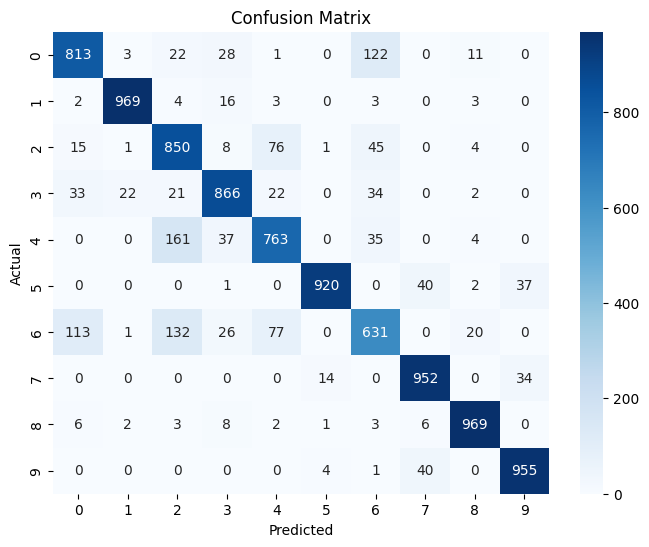

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix
import wandb

def initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size):
    weights = []
    biases = []
    layer_sizes = [input_size] + [num_nodes_hidden_layers] * num_hidden_layers + [output_size]

    for i in range(len(layer_sizes) - 1):
        weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(1. / layer_sizes[i]))
        biases.append(np.zeros((1, layer_sizes[i+1])))

    return weights, biases

def forward_propagation(X, weights, biases, num_hidden_layers, activation):
    activations = [X]
    for i in range(num_hidden_layers):
        z = np.dot(activations[-1], weights[i]) + biases[i]
        a = np.tanh(z)
        activations.append(a)

    z_out = np.dot(activations[-1], weights[-1]) + biases[-1]
    exp_scores = np.exp(z_out - np.max(z_out, axis=1, keepdims=True))
    activations.append(exp_scores / np.sum(exp_scores, axis=1, keepdims=True))
    return activations

def backward_propagation(X, Y, weights, biases, activations, num_hidden_layers):
    gradients_w = [None] * len(weights)
    gradients_b = [None] * len(biases)

    delta = activations[-1] - Y
    gradients_w[-1] = np.dot(activations[-2].T, delta) / X.shape[0]
    gradients_b[-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    for i in range(num_hidden_layers, 0, -1):
        delta = np.dot(delta, weights[i].T) * (1 - activations[i] ** 2)
        gradients_w[i-1] = np.dot(activations[i-1].T, delta) / X.shape[0]
        gradients_b[i-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    return gradients_w, gradients_b

def apply_nadam(weights, biases, gradients_w, gradients_b, lr, m_w, v_w, m_b, v_b, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
    for i in range(len(weights)):
        m_w[i] = beta1 * m_w[i] + (1 - beta1) * gradients_w[i]
        v_w[i] = beta2 * v_w[i] + (1 - beta2) * (gradients_w[i] ** 2)
        m_b[i] = beta1 * m_b[i] + (1 - beta1) * gradients_b[i]
        v_b[i] = beta2 * v_b[i] + (1 - beta2) * (gradients_b[i] ** 2)

        m_w_hat = m_w[i] / (1 - beta1 ** t)
        v_w_hat = v_w[i] / (1 - beta2 ** t)
        m_b_hat = m_b[i] / (1 - beta1 ** t)
        v_b_hat = v_b[i] / (1 - beta2 ** t)

        weights[i] -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
        biases[i] -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

    return weights, biases, m_w, v_w, m_b, v_b

def calculate_accuracy(X, Y, weights, biases, num_hidden_layers):
    activations = forward_propagation(X, weights, biases, num_hidden_layers, activation='tanh')
    predictions = np.argmax(activations[-1], axis=1)
    labels = np.argmax(Y, axis=1)
    return accuracy_score(labels, predictions)

def plot_confusion_matrix(X, Y, weights, biases, num_hidden_layers):
    wandb.init(project="Assignment1")
    activations = forward_propagation(X, weights, biases, num_hidden_layers, activation='tanh')
    predictions = np.argmax(activations[-1], axis=1)
    labels = np.argmax(Y, axis=1)
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix.png")
    wandb.log({"Confusion Matrix": wandb.Image("confusion_matrix.png")})
    plt.show()
    wandb.finish()

def nadam_optimizer(lr, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, epochs, num_hidden_layers, num_nodes_hidden_layers, batch_size, input_size, output_size):
    weights, biases = initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size)
    m_w = [np.zeros_like(w) for w in weights]
    v_w = [np.zeros_like(w) for w in weights]
    m_b = [np.zeros_like(b) for b in biases]
    v_b = [np.zeros_like(b) for b in biases]

    t = 0
    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = Y_train[i:i+batch_size]
            activations = forward_propagation(x_batch, weights, biases, num_hidden_layers, activation='tanh')
            gradients_w, gradients_b = backward_propagation(x_batch, y_batch, weights, biases, activations, num_hidden_layers)
            t += 1
            weights, biases, m_w, v_w, m_b, v_b = apply_nadam(weights, biases, gradients_w, gradients_b, lr, m_w, v_w, m_b, v_b, t)

        train_acc = calculate_accuracy(X_train, Y_train, weights, biases, num_hidden_layers)
        val_acc = calculate_accuracy(X_valid, Y_valid, weights, biases, num_hidden_layers)
        print(f"Epoch {epoch + 1}/{epochs}, Train Accuracy: {train_acc:.2f}, Validation Accuracy: {val_acc:.2f}")

    test_acc = calculate_accuracy(X_test, Y_test, weights, biases, num_hidden_layers)
    print(f"Test Accuracy: {test_acc:.2f}")
    plot_confusion_matrix(X_test, Y_test, weights, biases, num_hidden_layers)

(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train, X_test = X_train.reshape(-1, 28*28) / 255.0, X_test.reshape(-1, 28*28) / 255.0
Y_train, Y_test = to_categorical(Y_train, 10), to_categorical(Y_test, 10)

split_idx = int(0.8 * X_train.shape[0])
X_valid, Y_valid = X_train[split_idx:], Y_train[split_idx:]
X_train, Y_train = X_train[:split_idx], Y_train[:split_idx]

nadam_optimizer(0.001, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, 10, 3, 64, 16, 28*28, 10)


In [ ]:
import wandb

wandb.init(project="Assignment1", name="Confusion Matrix Logging")
wandb.log({"Confusion Matrix": wandb.Image("/content/confusion_matrix.png")})
wandb.finish()


**Question 8**
In all the models above you would have used cross entropy loss. Now compare the cross entropy loss with the squared error loss. I would again like to see some automatically generated plots or your own plots to convince me whether one is better than the other.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ajay-madkami-iitm (ajay-madkami-iitm-indian-institute-of-technology-mad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10, Loss: 0.3871, Validation Accuracy: 83.69%
Epoch 2/10, Loss: 0.3208, Validation Accuracy: 85.68%
Epoch 3/10, Loss: 0.2922, Validation Accuracy: 86.53%
Epoch 4/10, Loss: 0.2804, Validation Accuracy: 86.59%
Epoch 5/10, Loss: 0.2512, Validation Accuracy: 86.78%
Epoch 6/10, Loss: 0.2517, Validation Accuracy: 86.91%
Epoch 7/10, Loss: 0.2529, Validation Accuracy: 86.97%
Epoch 8/10, Loss: 0.2465, Validation Accuracy: 86.83%
Epoch 9/10, Loss: 0.2279, Validation Accuracy: 87.20%
Epoch 10/10, Loss: 0.2312, Validation Accuracy: 87.33%


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▂▁▁
validation_accuracy,▁▅▆▇▇▇▇▇██
epoch,10
loss,0.2312
validation_accuracy,87.33333


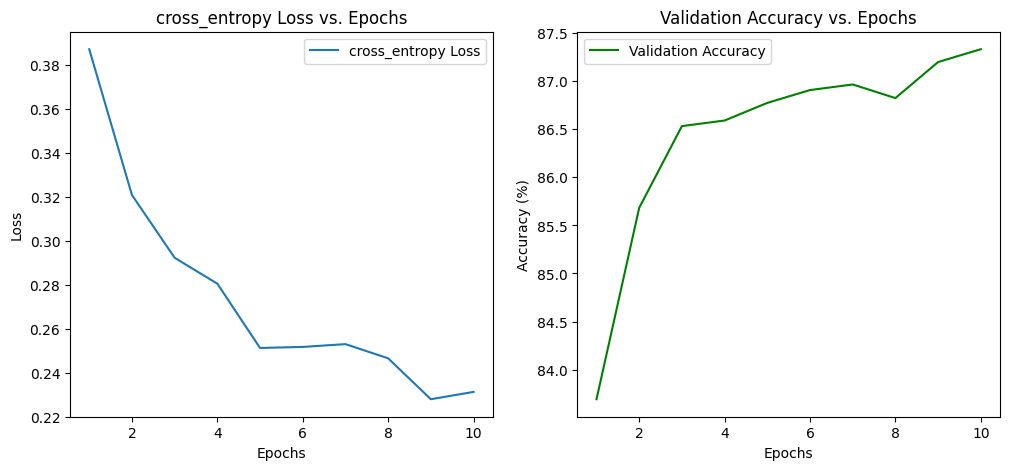

Epoch 1/10, Loss: 0.3484, Validation Accuracy: 72.40%
Epoch 2/10, Loss: 0.2650, Validation Accuracy: 79.70%
Epoch 3/10, Loss: 0.2245, Validation Accuracy: 82.62%
Epoch 4/10, Loss: 0.2033, Validation Accuracy: 83.49%
Epoch 5/10, Loss: 0.1911, Validation Accuracy: 84.12%
Epoch 6/10, Loss: 0.1825, Validation Accuracy: 84.62%
Epoch 7/10, Loss: 0.1752, Validation Accuracy: 85.21%
Epoch 8/10, Loss: 0.1700, Validation Accuracy: 85.62%
Epoch 9/10, Loss: 0.1655, Validation Accuracy: 85.95%
Epoch 10/10, Loss: 0.1617, Validation Accuracy: 86.33%


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▃▂▂▂▁▁▁
validation_accuracy,▁▅▆▇▇▇▇███
epoch,10
loss,0.16173
validation_accuracy,86.33333


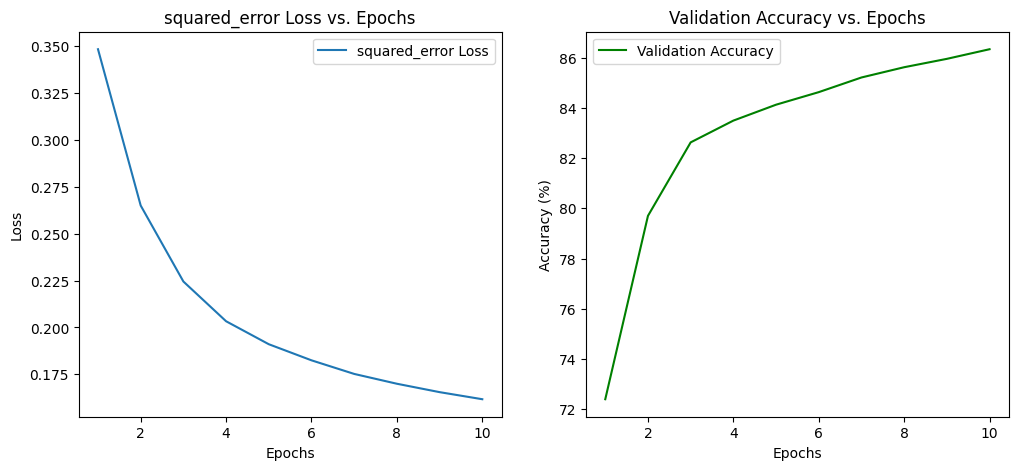

In [ ]:
import numpy as np
import wandb
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

def initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size):
    weights = []
    biases = []
    layer_sizes = [input_size] + [num_nodes_hidden_layers] * num_hidden_layers + [output_size]

    for i in range(len(layer_sizes) - 1):
        # Xavier Initialization
        weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(1. / layer_sizes[i]))
        biases.append(np.zeros((1, layer_sizes[i+1])))

    return weights, biases

def apply_momentum(weights, biases, gradients_w, gradients_b, lr, velocity_w, velocity_b, momentum=0.9):
    for i in range(len(weights)):
        velocity_w[i] = momentum * velocity_w[i] - lr * gradients_w[i]
        velocity_b[i] = momentum * velocity_b[i] - lr * gradients_b[i]
        weights[i] += velocity_w[i]
        biases[i] += velocity_b[i]
    return weights, biases, velocity_w, velocity_b

def forward_propagation(X, weights, biases, num_hidden_layers, activation, loss_type):
    activations = [X]

    # Hidden layers
    for i in range(num_hidden_layers):
        z = np.dot(activations[-1], weights[i]) + biases[i]
        a = np.maximum(0, z) if activation == 'relu' else 1 / (1 + np.exp(-z))
        activations.append(a)

    # Output layer
    z_out = np.dot(activations[-1], weights[-1]) + biases[-1]

    if loss_type == "cross_entropy":
        exp_scores = np.exp(z_out - np.max(z_out, axis=1, keepdims=True))
        activations.append(exp_scores / np.sum(exp_scores, axis=1, keepdims=True))  # Softmax
    else:
        activations.append(1 / (1 + np.exp(-z_out)))  # Sigmoid for squared error loss

    return activations

def backward_propagation(X, Y, weights, activations, num_hidden_layers, loss_type):
    gradients_w = [None] * len(weights)
    gradients_b = [None] * len(weights)

    if loss_type == "cross_entropy":
        delta = activations[-1] - Y  # Softmax derivative
    else:
        delta = (activations[-1] - Y) * (activations[-1] * (1 - activations[-1]))  # Squared Error Loss derivative

    gradients_w[-1] = np.dot(activations[-2].T, delta) / X.shape[0]
    gradients_b[-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    for i in range(num_hidden_layers, 0, -1):
        delta = np.dot(delta, weights[i].T) * (activations[i] > 0)
        gradients_w[i-1] = np.dot(activations[i-1].T, delta) / X.shape[0]
        gradients_b[i-1] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

    return gradients_w, gradients_b

def cross_entropy_loss(predictions, Y):
    return -np.mean(np.sum(Y * np.log(predictions + 1e-9), axis=1))

def squared_error_loss(predictions, Y):
    return np.mean(np.sum((predictions - Y) ** 2, axis=1))

def calculate_accuracy(X_test, Y_test, weights, biases, num_hidden_layers, activation, loss_type):
    activations = forward_propagation(X_test, weights, biases, num_hidden_layers, activation, loss_type)
    predictions = np.argmax(activations[-1], axis=1)
    actual = np.argmax(Y_test, axis=1)
    return np.mean(predictions == actual) * 100

def momentum_optimizer(lr, X_train, Y_train, X_valid, Y_valid, epochs, activation, num_hidden_layers, num_nodes_hidden_layers, batch_size, input_size, output_size, momentum=0.9, loss_type="cross_entropy"):
    wandb.init(project="Assignment1", name=f"Momentum-{loss_type}")

    weights, biases = initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size)
    velocity_w = [np.zeros_like(w) for w in weights]
    velocity_b = [np.zeros_like(b) for b in biases]

    loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = Y_train[i:i+batch_size]
            activations = forward_propagation(x_batch, weights, biases, num_hidden_layers, activation, loss_type)
            gradients_w, gradients_b = backward_propagation(x_batch, y_batch, weights, activations, num_hidden_layers, loss_type)
            weights, biases, velocity_w, velocity_b = apply_momentum(weights, biases, gradients_w, gradients_b, lr, velocity_w, velocity_b, momentum)

        val_acc = calculate_accuracy(X_valid, Y_valid, weights, biases, num_hidden_layers, activation, loss_type)
        loss = cross_entropy_loss(activations[-1], y_batch) if loss_type == "cross_entropy" else squared_error_loss(activations[-1], y_batch)

        loss_history.append(loss)
        val_acc_history.append(val_acc)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        wandb.log({"epoch": epoch + 1, "loss": loss, "validation_accuracy": val_acc})

    wandb.finish()

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), loss_history, label=f'{loss_type} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{loss_type} Loss vs. Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), val_acc_history, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy vs. Epochs')
    plt.legend()

    plt.show()

# Load data and preprocess
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train, X_test = X_train.reshape(-1, 28*28) / 255.0, X_test.reshape(-1, 28*28) / 255.0
Y_train, Y_test = to_categorical(Y_train, 10), to_categorical(Y_test, 10)

# Split train into train and validation sets
split_idx = int(0.8 * X_train.shape[0])
X_valid, Y_valid = X_train[split_idx:], Y_train[split_idx:]
X_train, Y_train = X_train[:split_idx], Y_train[:split_idx]

# Run momentum optimizer for both loss functions
momentum_optimizer(lr=0.01, X_train=X_train, Y_train=Y_train, X_valid=X_valid, Y_valid=Y_valid,
                   epochs=10, activation='relu', num_hidden_layers=2, num_nodes_hidden_layers=128,
                   batch_size=64, input_size=28*28, output_size=10, momentum=0.9, loss_type="cross_entropy")

momentum_optimizer(lr=0.01, X_train=X_train, Y_train=Y_train, X_valid=X_valid, Y_valid=Y_valid,
                   epochs=10, activation='relu', num_hidden_layers=2, num_nodes_hidden_layers=128,
                   batch_size=64, input_size=28*28, output_size=10, momentum=0.9, loss_type="squared_error")


### MSE SWEEP CONFIG

In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

def initialize_network(num_hidden_layers, num_nodes_hidden_layers, input_size, output_size, init_method):
    weights, biases, velocities_w, velocities_b, moment_w, moment_b = [], [], [], [], [], []
    layer_sizes = [input_size] + [num_nodes_hidden_layers] * num_hidden_layers + [output_size]

    for i in range(len(layer_sizes) - 1):
        if init_method == "xavier":
            weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(1. / layer_sizes[i]))
        else:
            weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01)
        biases.append(np.zeros((1, layer_sizes[i+1])))
        velocities_w.append(np.zeros_like(weights[-1]))
        velocities_b.append(np.zeros_like(biases[-1]))
        moment_w.append(np.zeros_like(weights[-1]))
        moment_b.append(np.zeros_like(biases[-1]))

    return weights, biases, velocities_w, velocities_b, moment_w, moment_b

def forward_propagation(X, weights, biases, activation):
    activations = [X]
    for i in range(len(weights) - 1):
        Z = np.dot(activations[-1], weights[i]) + biases[i]
        if activation == "relu":
            A = np.maximum(0, Z)
        elif activation == "tanh":
            A = np.tanh(Z)
        else:
            A = 1 / (1 + np.exp(-Z))
        activations.append(A)

    Z_final = np.dot(activations[-1], weights[-1]) + biases[-1]
    exp_vals = np.exp(Z_final - np.max(Z_final, axis=1, keepdims=True))
    activations.append(exp_vals / np.sum(exp_vals, axis=1, keepdims=True))
    return activations

def backward_propagation(X, Y, weights, biases, activations, activation):
    gradients_w, gradients_b = [None] * len(weights), [None] * len(biases)
    dA = activations[-1] - Y

    for i in reversed(range(len(weights))):
        dZ = dA
        gradients_w[i] = np.dot(activations[i].T, dZ) / X.shape[0]
        gradients_b[i] = np.sum(dZ, axis=0, keepdims=True) / X.shape[0]
        if i > 0:
            dA = np.dot(dZ, weights[i].T)
            if activation == "relu":
                dA[activations[i] <= 0] = 0
            elif activation == "tanh":
                dA *= 1 - activations[i] ** 2

    return gradients_w, gradients_b

def compute_loss(Y, predictions, loss_type):
    if loss_type == "cross_entropy":
        return -np.mean(Y * np.log(predictions + 1e-8))
    elif loss_type == "mse":
        return np.mean((Y - predictions) ** 2)

def compute_accuracy(y_true, y_pred):
    """
    Compute accuracy by comparing predicted labels with true labels.

    Args:
    - y_true: Ground truth labels (one-hot encoded or class indices).
    - y_pred: Model predictions (raw scores or probabilities).

    Returns:
    - Accuracy as a float between 0 and 1.
    """
    # Convert predictions to class indices if they are probabilities
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Convert one-hot encoded true labels to class indices if needed
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true_labels = np.argmax(y_true, axis=1)
    else:
        y_true_labels = y_true  # Already class indices

    accuracy = np.mean(y_pred_labels == y_true_labels)
    return accuracy

def train_model():
    wandb.init(project='Assignment1')
    config = wandb.config

    weights, biases, velocities_w, velocities_b, moment_w, moment_b = initialize_network(
        config.num_hidden_layers, config.num_hidden_nodes, 28*28, 10, config.init_method)

    for epoch in range(config.epochs):
        for i in range(0, X_train.shape[0], config.batch_size):
            x_batch = X_train[i:i+config.batch_size]
            y_batch = Y_train[i:i+config.batch_size]

            activations = forward_propagation(x_batch, weights, biases, config.activation)
            gradients_w, gradients_b = backward_propagation(x_batch, y_batch, weights, biases, activations, config.activation)

            for j in range(len(weights)):
                weights[j] -= config.learning_rate * gradients_w[j]
                biases[j] -= config.learning_rate * gradients_b[j]

        predictions_train = forward_propagation(X_train, weights, biases, config.activation)[-1]
        predictions_val = forward_propagation(X_valid, weights, biases, config.activation)[-1]

        train_loss = compute_loss(Y_train, predictions_train, config.loss)
        val_loss = compute_loss(Y_valid, predictions_val, config.loss)

        train_acc = compute_accuracy(Y_train, predictions_train)
        val_acc = compute_accuracy(Y_valid, predictions_val)

        print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss, "train_acc": train_acc, "val_acc": val_acc})

    wandb.finish()

(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train, X_test = X_train.reshape(-1, 28*28) / 255.0, X_test.reshape(-1, 28*28) / 255.0
Y_train, Y_test = to_categorical(Y_train, 10), to_categorical(Y_test, 10)
split_idx = int(0.8 * X_train.shape[0])
X_valid, Y_valid = X_train[split_idx:], Y_train[split_idx:]
X_train, Y_train = X_train[:split_idx], Y_train[:split_idx]

sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'num_hidden_nodes': {'values': [32, 64, 128]},
        'batch_size': {'values': [16, 32, 64]},
        'learning_rate': {'values': [0.0001, 0.001]},
        'activation': {'values': ['relu', 'tanh', 'sigmoid']},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'init_method': {'values': ['xavier', 'random']},
        'loss': {'values': ['mse']}  # Added loss function
    }
}


sweep_id = wandb.sweep(sweep=sweep_config, project='Assignment1')
wandb.agent(sweep_id, function=train_model, count=50)


epoch,▁█
train_acc,▁▁
train_loss,█▁
val_acc,▁▁
val_loss,▁█
epoch,2
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


Create sweep with ID: mcgkxgsu
Sweep URL: https://wandb.ai/ajay-madkami-iitm-indian-institute-of-technology-mad/Assignment1/sweeps/mcgkxgsu


wandb: Agent Starting Run: rrvko209 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: sgd


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2493, Val Acc: 0.2527
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2493, Val Acc: 0.2527
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2493, Val Acc: 0.2527
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2493, Val Acc: 0.2527
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2493, Val Acc: 0.2527


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▅▃▂▁
val_acc,▁▁▁▁▁
val_loss,█▂▁▂▃
epoch,5
train_acc,0.24933
train_loss,0.09
val_acc,0.25267
val_loss,0.09


wandb: Agent Starting Run: spihs5u1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: rmsprop


Epoch 1/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2499, Val Acc: 0.2503
Epoch 2/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 3/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 4/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 5/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 6/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 7/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 8/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 9/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 10/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁█████████
train_loss,█▁▁▁▁▁▁▁▁▁
val_acc,█▁▁▁▁▁▁▁▁▁
val_loss,▁▇████████
epoch,10
train_acc,0.25042
train_loss,0.09
val_acc,0.24833
val_loss,0.09


wandb: Agent Starting Run: 6plqwres with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: rmsprop


Epoch 1/5, Train Loss: 0.0831, Val Loss: 0.0830, Train Acc: 0.6502, Val Acc: 0.6520
Epoch 2/5, Train Loss: 0.0776, Val Loss: 0.0775, Train Acc: 0.6969, Val Acc: 0.6949
Epoch 3/5, Train Loss: 0.0727, Val Loss: 0.0725, Train Acc: 0.7201, Val Acc: 0.7186
Epoch 4/5, Train Loss: 0.0684, Val Loss: 0.0683, Train Acc: 0.7400, Val Acc: 0.7415
Epoch 5/5, Train Loss: 0.0649, Val Loss: 0.0647, Train Acc: 0.7574, Val Acc: 0.7609


epoch,▁▃▅▆█
train_acc,▁▄▆▇█
train_loss,█▆▄▂▁
val_acc,▁▄▅▇█
val_loss,█▆▄▂▁
epoch,5
train_acc,0.7574
train_loss,0.06487
val_acc,0.76092
val_loss,0.06469


wandb: Agent Starting Run: v1gdgrf4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: sgd


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▆▄▃▁
val_acc,▁▁▁▁▁
val_loss,▁▅▇█▇
epoch,5
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fjbvc4p4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: rmsprop


Epoch 1/10, Train Loss: 0.0840, Val Loss: 0.0839, Train Acc: 0.3954, Val Acc: 0.4000
Epoch 2/10, Train Loss: 0.0763, Val Loss: 0.0760, Train Acc: 0.5722, Val Acc: 0.5734
Epoch 3/10, Train Loss: 0.0688, Val Loss: 0.0683, Train Acc: 0.6562, Val Acc: 0.6685
Epoch 4/10, Train Loss: 0.0597, Val Loss: 0.0592, Train Acc: 0.7775, Val Acc: 0.7850
Epoch 5/10, Train Loss: 0.0504, Val Loss: 0.0499, Train Acc: 0.8023, Val Acc: 0.8115
Epoch 6/10, Train Loss: 0.0448, Val Loss: 0.0443, Train Acc: 0.8167, Val Acc: 0.8260
Epoch 7/10, Train Loss: 0.0417, Val Loss: 0.0413, Train Acc: 0.8326, Val Acc: 0.8407
Epoch 8/10, Train Loss: 0.0398, Val Loss: 0.0394, Train Acc: 0.8511, Val Acc: 0.8583
Epoch 9/10, Train Loss: 0.0382, Val Loss: 0.0379, Train Acc: 0.8688, Val Acc: 0.8752
Epoch 10/10, Train Loss: 0.0367, Val Loss: 0.0365, Train Acc: 0.8860, Val Acc: 0.8909


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▇▇▇███
train_loss,█▇▆▄▃▂▂▁▁▁
val_acc,▁▃▅▆▇▇▇███
val_loss,█▇▆▄▃▂▂▁▁▁
epoch,10
train_acc,0.88602
train_loss,0.03674
val_acc,0.89092
val_loss,0.03649


wandb: Agent Starting Run: iwijl4si with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: momentum


Epoch 1/5, Train Loss: 0.0714, Val Loss: 0.0711, Train Acc: 0.6743, Val Acc: 0.6768
Epoch 2/5, Train Loss: 0.0479, Val Loss: 0.0474, Train Acc: 0.8071, Val Acc: 0.8162
Epoch 3/5, Train Loss: 0.0400, Val Loss: 0.0396, Train Acc: 0.8605, Val Acc: 0.8696
Epoch 4/5, Train Loss: 0.0362, Val Loss: 0.0359, Train Acc: 0.8947, Val Acc: 0.9016
Epoch 5/5, Train Loss: 0.0333, Val Loss: 0.0332, Train Acc: 0.9193, Val Acc: 0.9238


epoch,▁▃▅▆█
train_acc,▁▅▆▇█
train_loss,█▄▂▂▁
val_acc,▁▅▆▇█
val_loss,█▄▂▁▁
epoch,5
train_acc,0.91925
train_loss,0.03334
val_acc,0.92375
val_loss,0.03319


wandb: Agent Starting Run: twv7a4mn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: rmsprop


Epoch 1/10, Train Loss: 0.0894, Val Loss: 0.0894, Train Acc: 0.4283, Val Acc: 0.4315
Epoch 2/10, Train Loss: 0.0835, Val Loss: 0.0835, Train Acc: 0.4071, Val Acc: 0.4050


<ipython-input-8-9c16536777d7>:32: RuntimeWarning: overflow encountered in exp
  A = 1 / (1 + np.exp(-Z))


Epoch 3/10, Train Loss: 0.0809, Val Loss: 0.0810, Train Acc: 0.3702, Val Acc: 0.3714
Epoch 4/10, Train Loss: 0.0808, Val Loss: 0.0809, Train Acc: 0.3687, Val Acc: 0.3712
Epoch 5/10, Train Loss: 0.0807, Val Loss: 0.0807, Train Acc: 0.3678, Val Acc: 0.3709
Epoch 6/10, Train Loss: 0.0805, Val Loss: 0.0805, Train Acc: 0.3695, Val Acc: 0.3712
Epoch 7/10, Train Loss: 0.0802, Val Loss: 0.0803, Train Acc: 0.3731, Val Acc: 0.3742
Epoch 8/10, Train Loss: 0.0799, Val Loss: 0.0800, Train Acc: 0.3779, Val Acc: 0.3787
Epoch 9/10, Train Loss: 0.0796, Val Loss: 0.0798, Train Acc: 0.3827, Val Acc: 0.3839
Epoch 10/10, Train Loss: 0.0793, Val Loss: 0.0795, Train Acc: 0.3861, Val Acc: 0.3882


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,█▆▁▁▁▁▂▂▃▃
train_loss,█▄▂▂▂▂▂▁▁▁
val_acc,█▅▁▁▁▁▁▂▃▃
val_loss,█▄▂▂▂▂▂▁▁▁
epoch,10
train_acc,0.3861
train_loss,0.07929
val_acc,0.38817
val_loss,0.07948


wandb: Agent Starting Run: o15wrgub with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: nesterov


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▅▃▂▁
val_acc,▁▁▁▁▁
val_loss,▁▃▅▇█
epoch,5
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: rum396qb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: nadam


Epoch 1/5, Train Loss: 0.0911, Val Loss: 0.0911, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 2/5, Train Loss: 0.0908, Val Loss: 0.0908, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 3/5, Train Loss: 0.0905, Val Loss: 0.0905, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 4/5, Train Loss: 0.0904, Val Loss: 0.0904, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 5/5, Train Loss: 0.0903, Val Loss: 0.0903, Train Acc: 0.2504, Val Acc: 0.2483


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▅▃▂▁
val_acc,▁▁▁▁▁
val_loss,█▅▃▂▁
epoch,5
train_acc,0.25042
train_loss,0.09026
val_acc,0.24833
val_loss,0.09027


wandb: Agent Starting Run: e0ckz8b8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: nadam


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2499, Val Acc: 0.2503
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2499, Val Acc: 0.2503
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2499, Val Acc: 0.2503
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2499, Val Acc: 0.2503
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2499, Val Acc: 0.2503


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▆▄▂▁
val_acc,▁▁▁▁▁
val_loss,█▅▃▂▁
epoch,5
train_acc,0.24992
train_loss,0.09
val_acc,0.25033
val_loss,0.09


wandb: Agent Starting Run: sefjkyhx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: nesterov


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▆▅▃▁
val_acc,▁▁▁▁▁
val_loss,▁▃▅▆█
epoch,5
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: jengt4t9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: sgd


Epoch 1/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 6/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 7/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 8/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 9/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 10/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▄▄▃▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▃▆▇███▆▅▃▁
epoch,10
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: 05d5q4ct with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: adam


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2499, Val Acc: 0.2503
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483


epoch,▁▃▅▆█
train_acc,▁████
train_loss,█▁▁▁▁
val_acc,█▁▁▁▁
val_loss,▁▄▇██
epoch,5
train_acc,0.25042
train_loss,0.09
val_acc,0.24833
val_loss,0.09


wandb: Agent Starting Run: 1d6cdh98 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: nadam


Epoch 1/5, Train Loss: 0.0885, Val Loss: 0.0884, Train Acc: 0.3144, Val Acc: 0.3195
Epoch 2/5, Train Loss: 0.0871, Val Loss: 0.0870, Train Acc: 0.4088, Val Acc: 0.4117
Epoch 3/5, Train Loss: 0.0855, Val Loss: 0.0855, Train Acc: 0.4946, Val Acc: 0.4998
Epoch 4/5, Train Loss: 0.0837, Val Loss: 0.0837, Train Acc: 0.5589, Val Acc: 0.5650
Epoch 5/5, Train Loss: 0.0816, Val Loss: 0.0815, Train Acc: 0.6284, Val Acc: 0.6320


epoch,▁▃▅▆█
train_acc,▁▃▅▆█
train_loss,█▇▅▃▁
val_acc,▁▃▅▆█
val_loss,█▇▅▃▁
epoch,5
train_acc,0.62835
train_loss,0.08156
val_acc,0.632
val_loss,0.08146


wandb: Agent Starting Run: nhx5svna with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: nesterov


Epoch 1/5, Train Loss: 0.0763, Val Loss: 0.0761, Train Acc: 0.6062, Val Acc: 0.6125
Epoch 2/5, Train Loss: 0.0649, Val Loss: 0.0647, Train Acc: 0.7030, Val Acc: 0.7099
Epoch 3/5, Train Loss: 0.0565, Val Loss: 0.0562, Train Acc: 0.7814, Val Acc: 0.7880
Epoch 4/5, Train Loss: 0.0506, Val Loss: 0.0502, Train Acc: 0.8202, Val Acc: 0.8281
Epoch 5/5, Train Loss: 0.0462, Val Loss: 0.0458, Train Acc: 0.8424, Val Acc: 0.8470


epoch,▁▃▅▆█
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_acc,0.84244
train_loss,0.04619
val_acc,0.847
val_loss,0.04581


wandb: Agent Starting Run: 9i8uapz5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: rmsprop


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▅▄▂▁
val_acc,▁▁▁▁▁
val_loss,▁▃▅▇█
epoch,5
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: lou16rrh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: adam


Epoch 1/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 6/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 7/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 8/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 9/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 10/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▅▅▄▄▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▃▄▅▆▆▇█
epoch,10
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: hb9falny with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: momentum


Epoch 1/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 6/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 7/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 8/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 9/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 10/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▄▄▃▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▃▄▅▆▇▇█
epoch,10
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: 1ydrawsk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: adam


Epoch 1/10, Train Loss: 0.0890, Val Loss: 0.0890, Train Acc: 0.4548, Val Acc: 0.4564
Epoch 2/10, Train Loss: 0.0876, Val Loss: 0.0877, Train Acc: 0.4771, Val Acc: 0.4779
Epoch 3/10, Train Loss: 0.0850, Val Loss: 0.0850, Train Acc: 0.5330, Val Acc: 0.5331
Epoch 4/10, Train Loss: 0.0819, Val Loss: 0.0820, Train Acc: 0.5281, Val Acc: 0.5286
Epoch 5/10, Train Loss: 0.0798, Val Loss: 0.0799, Train Acc: 0.5214, Val Acc: 0.5243
Epoch 6/10, Train Loss: 0.0783, Val Loss: 0.0784, Train Acc: 0.5216, Val Acc: 0.5289
Epoch 7/10, Train Loss: 0.0769, Val Loss: 0.0770, Train Acc: 0.5288, Val Acc: 0.5354
Epoch 8/10, Train Loss: 0.0755, Val Loss: 0.0756, Train Acc: 0.5306, Val Acc: 0.5361
Epoch 9/10, Train Loss: 0.0743, Val Loss: 0.0744, Train Acc: 0.5445, Val Acc: 0.5458
Epoch 10/10, Train Loss: 0.0731, Val Loss: 0.0732, Train Acc: 0.5554, Val Acc: 0.5567


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▆▆▆▆▆▇█
train_loss,█▇▆▅▄▃▃▂▂▁
val_acc,▁▃▆▆▆▆▇▇▇█
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,10
train_acc,0.55537
train_loss,0.07308
val_acc,0.55667
val_loss,0.07319


wandb: Agent Starting Run: 68aa8xiv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: nesterov


Epoch 1/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2492, Val Acc: 0.2530
Epoch 2/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2492, Val Acc: 0.2530
Epoch 3/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 4/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 5/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 6/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 7/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 8/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 9/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 10/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁████████
train_loss,█▃▂▁▁▁▁▁▁▁
val_acc,██▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_acc,0.25042
train_loss,0.09
val_acc,0.24833
val_loss,0.09


wandb: Agent Starting Run: k2mzsqhn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: adam


Epoch 1/10, Train Loss: 0.0631, Val Loss: 0.0629, Train Acc: 0.7810, Val Acc: 0.7876
Epoch 2/10, Train Loss: 0.0487, Val Loss: 0.0484, Train Acc: 0.8410, Val Acc: 0.8485
Epoch 3/10, Train Loss: 0.0412, Val Loss: 0.0409, Train Acc: 0.8804, Val Acc: 0.8846
Epoch 4/10, Train Loss: 0.0367, Val Loss: 0.0365, Train Acc: 0.9029, Val Acc: 0.9053
Epoch 5/10, Train Loss: 0.0336, Val Loss: 0.0335, Train Acc: 0.9209, Val Acc: 0.9230
Epoch 6/10, Train Loss: 0.0314, Val Loss: 0.0313, Train Acc: 0.9361, Val Acc: 0.9347
Epoch 7/10, Train Loss: 0.0296, Val Loss: 0.0296, Train Acc: 0.9485, Val Acc: 0.9459
Epoch 8/10, Train Loss: 0.0282, Val Loss: 0.0283, Train Acc: 0.9570, Val Acc: 0.9543
Epoch 9/10, Train Loss: 0.0270, Val Loss: 0.0273, Train Acc: 0.9634, Val Acc: 0.9605
Epoch 10/10, Train Loss: 0.0261, Val Loss: 0.0264, Train Acc: 0.9691, Val Acc: 0.9660


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▆▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_acc,0.96906
train_loss,0.02613
val_acc,0.966
val_loss,0.02644


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mm9mohw2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: adam


Epoch 1/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 2/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 3/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 4/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 5/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 6/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 7/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 8/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 9/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 10/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁
epoch,10
train_acc,0.25042
train_loss,0.09
val_acc,0.24833
val_loss,0.09


wandb: Agent Starting Run: bbytr6kf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: nadam


Epoch 1/10, Train Loss: 0.0848, Val Loss: 0.0848, Train Acc: 0.5466, Val Acc: 0.5432
Epoch 2/10, Train Loss: 0.0791, Val Loss: 0.0791, Train Acc: 0.6900, Val Acc: 0.6953
Epoch 3/10, Train Loss: 0.0735, Val Loss: 0.0734, Train Acc: 0.7415, Val Acc: 0.7499
Epoch 4/10, Train Loss: 0.0684, Val Loss: 0.0684, Train Acc: 0.7640, Val Acc: 0.7711
Epoch 5/10, Train Loss: 0.0640, Val Loss: 0.0639, Train Acc: 0.7852, Val Acc: 0.7919
Epoch 6/10, Train Loss: 0.0602, Val Loss: 0.0600, Train Acc: 0.8068, Val Acc: 0.8133
Epoch 7/10, Train Loss: 0.0568, Val Loss: 0.0566, Train Acc: 0.8219, Val Acc: 0.8303
Epoch 8/10, Train Loss: 0.0539, Val Loss: 0.0536, Train Acc: 0.8318, Val Acc: 0.8412
Epoch 9/10, Train Loss: 0.0513, Val Loss: 0.0511, Train Acc: 0.8411, Val Acc: 0.8486
Epoch 10/10, Train Loss: 0.0491, Val Loss: 0.0488, Train Acc: 0.8480, Val Acc: 0.8548


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▆▇▇▇███
train_loss,█▇▆▅▄▃▃▂▁▁
val_acc,▁▄▆▆▇▇▇███
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,10
train_acc,0.84798
train_loss,0.0491
val_acc,0.85475
val_loss,0.0488


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: of726zk5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: nesterov


Epoch 1/10, Train Loss: 0.0552, Val Loss: 0.0548, Train Acc: 0.8019, Val Acc: 0.8134
Epoch 2/10, Train Loss: 0.0398, Val Loss: 0.0393, Train Acc: 0.8554, Val Acc: 0.8661
Epoch 3/10, Train Loss: 0.0348, Val Loss: 0.0345, Train Acc: 0.9057, Val Acc: 0.9113
Epoch 4/10, Train Loss: 0.0311, Val Loss: 0.0311, Train Acc: 0.9371, Val Acc: 0.9348
Epoch 5/10, Train Loss: 0.0287, Val Loss: 0.0288, Train Acc: 0.9546, Val Acc: 0.9522
Epoch 6/10, Train Loss: 0.0270, Val Loss: 0.0273, Train Acc: 0.9662, Val Acc: 0.9636
Epoch 7/10, Train Loss: 0.0258, Val Loss: 0.0262, Train Acc: 0.9744, Val Acc: 0.9702
Epoch 8/10, Train Loss: 0.0249, Val Loss: 0.0254, Train Acc: 0.9798, Val Acc: 0.9738
Epoch 9/10, Train Loss: 0.0242, Val Loss: 0.0247, Train Acc: 0.9845, Val Acc: 0.9776
Epoch 10/10, Train Loss: 0.0236, Val Loss: 0.0242, Train Acc: 0.9880, Val Acc: 0.9802


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▅▃▃▂▂▁▁▁▁
val_acc,▁▃▅▆▇▇████
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
train_acc,0.98804
train_loss,0.02362
val_acc,0.98017
val_loss,0.0242


wandb: Agent Starting Run: 7qxenuri with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: nadam


Epoch 1/5, Train Loss: 0.0446, Val Loss: 0.0443, Train Acc: 0.8472, Val Acc: 0.8502
Epoch 2/5, Train Loss: 0.0359, Val Loss: 0.0358, Train Acc: 0.9093, Val Acc: 0.9102
Epoch 3/5, Train Loss: 0.0313, Val Loss: 0.0314, Train Acc: 0.9412, Val Acc: 0.9363
Epoch 4/5, Train Loss: 0.0285, Val Loss: 0.0287, Train Acc: 0.9567, Val Acc: 0.9541
Epoch 5/5, Train Loss: 0.0266, Val Loss: 0.0270, Train Acc: 0.9672, Val Acc: 0.9640


epoch,▁▃▅▆█
train_acc,▁▅▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
train_acc,0.96719
train_loss,0.02661
val_acc,0.964
val_loss,0.02697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kgocgrcm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: sgd


Epoch 1/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 6/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 7/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 8/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 9/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 10/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▅▄▃▃▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▄▅▅▆▇▇█
epoch,10
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: bpktxl1v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: nesterov


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▅▅▁▁
val_acc,▁▁▁▁▁
val_loss,▁▃▅▆█
epoch,5
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: 6gd171fh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: adam


Epoch 1/5, Train Loss: 0.0891, Val Loss: 0.0891, Train Acc: 0.5139, Val Acc: 0.5088
Epoch 2/5, Train Loss: 0.0871, Val Loss: 0.0872, Train Acc: 0.5441, Val Acc: 0.5470
Epoch 3/5, Train Loss: 0.0831, Val Loss: 0.0832, Train Acc: 0.5033, Val Acc: 0.5063
Epoch 4/5, Train Loss: 0.0809, Val Loss: 0.0811, Train Acc: 0.4972, Val Acc: 0.4999
Epoch 5/5, Train Loss: 0.0788, Val Loss: 0.0790, Train Acc: 0.5416, Val Acc: 0.5454


epoch,▁▃▅▆█
train_acc,▃█▂▁█
train_loss,█▇▄▂▁
val_acc,▂█▂▁█
val_loss,█▇▄▂▁
epoch,5
train_acc,0.54158
train_loss,0.07876
val_acc,0.54542
val_loss,0.07901


wandb: Agent Starting Run: gahg5fad with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: adam


Epoch 1/5, Train Loss: 0.0919, Val Loss: 0.0919, Train Acc: 0.2497, Val Acc: 0.2512
Epoch 2/5, Train Loss: 0.0916, Val Loss: 0.0915, Train Acc: 0.2497, Val Acc: 0.2512
Epoch 3/5, Train Loss: 0.0913, Val Loss: 0.0912, Train Acc: 0.2497, Val Acc: 0.2512
Epoch 4/5, Train Loss: 0.0911, Val Loss: 0.0910, Train Acc: 0.2497, Val Acc: 0.2512
Epoch 5/5, Train Loss: 0.0909, Val Loss: 0.0908, Train Acc: 0.2497, Val Acc: 0.2512


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▆▄▂▁
val_acc,▁▁▁▁▁
val_loss,█▆▄▂▁
epoch,5
train_acc,0.24969
train_loss,0.09088
val_acc,0.25125
val_loss,0.09084


wandb: Agent Starting Run: 795kt9c5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: momentum


Epoch 1/5, Train Loss: 0.0882, Val Loss: 0.0882, Train Acc: 0.3573, Val Acc: 0.3619
Epoch 2/5, Train Loss: 0.0853, Val Loss: 0.0852, Train Acc: 0.5350, Val Acc: 0.5432
Epoch 3/5, Train Loss: 0.0824, Val Loss: 0.0824, Train Acc: 0.5967, Val Acc: 0.6042
Epoch 4/5, Train Loss: 0.0798, Val Loss: 0.0797, Train Acc: 0.6340, Val Acc: 0.6422
Epoch 5/5, Train Loss: 0.0772, Val Loss: 0.0771, Train Acc: 0.6562, Val Acc: 0.6629


epoch,▁▃▅▆█
train_acc,▁▅▇▇█
train_loss,█▆▄▃▁
val_acc,▁▅▇██
val_loss,█▆▄▃▁
epoch,5
train_acc,0.65617
train_loss,0.07719
val_acc,0.66292
val_loss,0.07709


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m2pexn9e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: nadam


Epoch 1/10, Train Loss: 0.0816, Val Loss: 0.0815, Train Acc: 0.6285, Val Acc: 0.6310
Epoch 2/10, Train Loss: 0.0720, Val Loss: 0.0718, Train Acc: 0.7147, Val Acc: 0.7173
Epoch 3/10, Train Loss: 0.0642, Val Loss: 0.0640, Train Acc: 0.7631, Val Acc: 0.7703
Epoch 4/10, Train Loss: 0.0586, Val Loss: 0.0583, Train Acc: 0.7973, Val Acc: 0.8053
Epoch 5/10, Train Loss: 0.0544, Val Loss: 0.0540, Train Acc: 0.8174, Val Acc: 0.8274
Epoch 6/10, Train Loss: 0.0511, Val Loss: 0.0507, Train Acc: 0.8311, Val Acc: 0.8401
Epoch 7/10, Train Loss: 0.0484, Val Loss: 0.0480, Train Acc: 0.8425, Val Acc: 0.8507
Epoch 8/10, Train Loss: 0.0462, Val Loss: 0.0458, Train Acc: 0.8531, Val Acc: 0.8584
Epoch 9/10, Train Loss: 0.0443, Val Loss: 0.0439, Train Acc: 0.8625, Val Acc: 0.8668
Epoch 10/10, Train Loss: 0.0427, Val Loss: 0.0424, Train Acc: 0.8707, Val Acc: 0.8748


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▇▇▇███
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_acc,0.87073
train_loss,0.04273
val_acc,0.87475
val_loss,0.04237


wandb: Agent Starting Run: von3j3pa with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: momentum


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2378, Val Acc: 0.2397
Epoch 2/5, Train Loss: 0.0899, Val Loss: 0.0899, Train Acc: 0.2466, Val Acc: 0.2495
Epoch 3/5, Train Loss: 0.0898, Val Loss: 0.0898, Train Acc: 0.2535, Val Acc: 0.2569
Epoch 4/5, Train Loss: 0.0897, Val Loss: 0.0897, Train Acc: 0.2614, Val Acc: 0.2657
Epoch 5/5, Train Loss: 0.0896, Val Loss: 0.0896, Train Acc: 0.2722, Val Acc: 0.2782


epoch,▁▃▅▆█
train_acc,▁▃▄▆█
train_loss,█▆▄▃▁
val_acc,▁▃▄▆█
val_loss,█▆▄▃▁
epoch,5
train_acc,0.27219
train_loss,0.08958
val_acc,0.27817
val_loss,0.08956


wandb: Agent Starting Run: 0uibzj9b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: adam


Epoch 1/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 6/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 7/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 8/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 9/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 10/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▂▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▄▅▆▇▇███
epoch,10
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: qfebjgj3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: sgd


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,█▁▁▁▁
epoch,5
train_acc,0.25042
train_loss,0.09
val_acc,0.24833
val_loss,0.09


wandb: Agent Starting Run: 40w940sr with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: nadam


Epoch 1/10, Train Loss: 0.0888, Val Loss: 0.0888, Train Acc: 0.2982, Val Acc: 0.3005
Epoch 2/10, Train Loss: 0.0877, Val Loss: 0.0876, Train Acc: 0.3531, Val Acc: 0.3553
Epoch 3/10, Train Loss: 0.0862, Val Loss: 0.0861, Train Acc: 0.3820, Val Acc: 0.3849
Epoch 4/10, Train Loss: 0.0846, Val Loss: 0.0845, Train Acc: 0.4065, Val Acc: 0.4104
Epoch 5/10, Train Loss: 0.0828, Val Loss: 0.0827, Train Acc: 0.4510, Val Acc: 0.4603
Epoch 6/10, Train Loss: 0.0806, Val Loss: 0.0804, Train Acc: 0.5031, Val Acc: 0.5085
Epoch 7/10, Train Loss: 0.0778, Val Loss: 0.0776, Train Acc: 0.5354, Val Acc: 0.5444
Epoch 8/10, Train Loss: 0.0745, Val Loss: 0.0743, Train Acc: 0.5896, Val Acc: 0.5984
Epoch 9/10, Train Loss: 0.0709, Val Loss: 0.0706, Train Acc: 0.6884, Val Acc: 0.6957
Epoch 10/10, Train Loss: 0.0670, Val Loss: 0.0667, Train Acc: 0.7548, Val Acc: 0.7631


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▂▃▃▄▅▅▇█
train_loss,██▇▇▆▅▄▃▂▁
val_acc,▁▂▂▃▃▄▅▆▇█
val_loss,██▇▇▆▅▄▃▂▁
epoch,10
train_acc,0.75477
train_loss,0.06695
val_acc,0.76308
val_loss,0.06668


wandb: Agent Starting Run: dhab0p15 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: momentum


Epoch 1/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 6/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 7/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 8/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 9/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 10/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▄▅▆▇▇██
epoch,10
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: e1xfe800 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: momentum


Epoch 1/10, Train Loss: 0.0898, Val Loss: 0.0898, Train Acc: 0.2493, Val Acc: 0.2527
Epoch 2/10, Train Loss: 0.0897, Val Loss: 0.0897, Train Acc: 0.3670, Val Acc: 0.3705
Epoch 3/10, Train Loss: 0.0893, Val Loss: 0.0893, Train Acc: 0.3863, Val Acc: 0.3836
Epoch 4/10, Train Loss: 0.0881, Val Loss: 0.0882, Train Acc: 0.3482, Val Acc: 0.3464
Epoch 5/10, Train Loss: 0.0859, Val Loss: 0.0861, Train Acc: 0.3415, Val Acc: 0.3418
Epoch 6/10, Train Loss: 0.0843, Val Loss: 0.0845, Train Acc: 0.3428, Val Acc: 0.3437
Epoch 7/10, Train Loss: 0.0841, Val Loss: 0.0843, Train Acc: 0.3402, Val Acc: 0.3391
Epoch 8/10, Train Loss: 0.0842, Val Loss: 0.0844, Train Acc: 0.3368, Val Acc: 0.3359
Epoch 9/10, Train Loss: 0.0843, Val Loss: 0.0845, Train Acc: 0.3346, Val Acc: 0.3333
Epoch 10/10, Train Loss: 0.0845, Val Loss: 0.0846, Train Acc: 0.3333, Val Acc: 0.3287


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▇█▆▆▆▆▅▅▅
train_loss,██▇▆▃▁▁▁▁▁
val_acc,▁▇█▆▆▆▆▅▅▅
val_loss,██▇▆▃▁▁▁▁▁
epoch,10
train_acc,0.33331
train_loss,0.08448
val_acc,0.32875
val_loss,0.08464


wandb: Agent Starting Run: e4qugu7e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: adam


Epoch 1/10, Train Loss: 0.0831, Val Loss: 0.0830, Train Acc: 0.5784, Val Acc: 0.5813
Epoch 2/10, Train Loss: 0.0786, Val Loss: 0.0786, Train Acc: 0.6165, Val Acc: 0.6205
Epoch 3/10, Train Loss: 0.0749, Val Loss: 0.0748, Train Acc: 0.6830, Val Acc: 0.6862
Epoch 4/10, Train Loss: 0.0716, Val Loss: 0.0715, Train Acc: 0.7207, Val Acc: 0.7235
Epoch 5/10, Train Loss: 0.0687, Val Loss: 0.0686, Train Acc: 0.7418, Val Acc: 0.7433
Epoch 6/10, Train Loss: 0.0661, Val Loss: 0.0659, Train Acc: 0.7561, Val Acc: 0.7598
Epoch 7/10, Train Loss: 0.0637, Val Loss: 0.0635, Train Acc: 0.7700, Val Acc: 0.7725
Epoch 8/10, Train Loss: 0.0616, Val Loss: 0.0614, Train Acc: 0.7813, Val Acc: 0.7842
Epoch 9/10, Train Loss: 0.0597, Val Loss: 0.0594, Train Acc: 0.7915, Val Acc: 0.7945
Epoch 10/10, Train Loss: 0.0579, Val Loss: 0.0577, Train Acc: 0.8008, Val Acc: 0.8041


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▅▆▇▇▇██
train_loss,█▇▆▅▄▃▃▂▁▁
val_acc,▁▂▄▅▆▇▇▇██
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,10
train_acc,0.80083
train_loss,0.05791
val_acc,0.80408
val_loss,0.05768


wandb: Agent Starting Run: p81r395k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: adam


Epoch 1/5, Train Loss: 0.0905, Val Loss: 0.0905, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/5, Train Loss: 0.0901, Val Loss: 0.0901, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.3342, Val Acc: 0.3268
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2506, Val Acc: 0.2484


epoch,▁▃▅▆█
train_acc,▁▁▁█▁
train_loss,█▃▂▁▁
val_acc,▁▁▁█▁
val_loss,█▃▂▁▁
epoch,5
train_acc,0.25058
train_loss,0.08997
val_acc,0.24842
val_loss,0.08997


wandb: Agent Starting Run: 4f2e7yak with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: momentum


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,▁▇███
epoch,5
train_acc,0.25042
train_loss,0.09
val_acc,0.24833
val_loss,0.09


wandb: Agent Starting Run: brd7j10s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: adam


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▅▃▁▁
val_acc,▁▁▁▁▁
val_loss,▁▄▅▇█
epoch,5
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: 0rm0d4k6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: rmsprop


Epoch 1/10, Train Loss: 0.0854, Val Loss: 0.0853, Train Acc: 0.5290, Val Acc: 0.5359
Epoch 2/10, Train Loss: 0.0806, Val Loss: 0.0805, Train Acc: 0.6363, Val Acc: 0.6456
Epoch 3/10, Train Loss: 0.0761, Val Loss: 0.0759, Train Acc: 0.6812, Val Acc: 0.6880
Epoch 4/10, Train Loss: 0.0719, Val Loss: 0.0717, Train Acc: 0.7104, Val Acc: 0.7153
Epoch 5/10, Train Loss: 0.0682, Val Loss: 0.0680, Train Acc: 0.7362, Val Acc: 0.7409
Epoch 6/10, Train Loss: 0.0651, Val Loss: 0.0648, Train Acc: 0.7597, Val Acc: 0.7667
Epoch 7/10, Train Loss: 0.0623, Val Loss: 0.0619, Train Acc: 0.7780, Val Acc: 0.7873
Epoch 8/10, Train Loss: 0.0598, Val Loss: 0.0595, Train Acc: 0.7924, Val Acc: 0.8003
Epoch 9/10, Train Loss: 0.0577, Val Loss: 0.0572, Train Acc: 0.8025, Val Acc: 0.8132
Epoch 10/10, Train Loss: 0.0557, Val Loss: 0.0553, Train Acc: 0.8100, Val Acc: 0.8216


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇███
train_loss,█▇▆▅▄▃▃▂▁▁
val_acc,▁▄▅▅▆▇▇▇██
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,10
train_acc,0.80998
train_loss,0.05569
val_acc,0.82158
val_loss,0.05525


wandb: Agent Starting Run: fbde4b3h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: sgd


Epoch 1/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2499, Val Acc: 0.2505
Epoch 2/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2499, Val Acc: 0.2505
Epoch 3/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2499, Val Acc: 0.2505
Epoch 4/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 6/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 7/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 8/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 9/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 10/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▁███████
train_loss,█▅▃▂▂▁▁▁▁▁
val_acc,███▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: z8fozcjw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: adam


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▆▄▃▁
val_acc,▁▁▁▁▁
val_loss,▁▃▅▆█
epoch,5
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: spsmodc0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: sgd


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▆▄▃▁
val_acc,▁▁▁▁▁
val_loss,▁▃▅▆█
epoch,5
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: cgs01sn9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 128
wandb: 	optimizer: nadam


Epoch 1/5, Train Loss: 0.0650, Val Loss: 0.0648, Train Acc: 0.7802, Val Acc: 0.7839
Epoch 2/5, Train Loss: 0.0523, Val Loss: 0.0520, Train Acc: 0.8112, Val Acc: 0.8137
Epoch 3/5, Train Loss: 0.0459, Val Loss: 0.0456, Train Acc: 0.8390, Val Acc: 0.8441
Epoch 4/5, Train Loss: 0.0420, Val Loss: 0.0417, Train Acc: 0.8619, Val Acc: 0.8653
Epoch 5/5, Train Loss: 0.0392, Val Loss: 0.0390, Train Acc: 0.8805, Val Acc: 0.8834


epoch,▁▃▅▆█
train_acc,▁▃▅▇█
train_loss,█▅▃▂▁
val_acc,▁▃▅▇█
val_loss,█▅▃▂▁
epoch,5
train_acc,0.8805
train_loss,0.03922
val_acc,0.88342
val_loss,0.03901


wandb: Agent Starting Run: bb4bpvr2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: nesterov


Epoch 1/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 6/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 7/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 8/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 9/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 10/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▅▄▃▂▂▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▂▃▄▅▆▆▇█
epoch,10
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


wandb: Agent Starting Run: euaz0b8i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: nesterov


Epoch 1/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 2/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 3/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 4/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 5/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 6/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 7/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 8/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 9/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 10/10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▆████████
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▇████████
epoch,10
train_acc,0.25042
train_loss,0.09
val_acc,0.24833
val_loss,0.09


wandb: Agent Starting Run: n3n45m8c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 5
wandb: 	num_hidden_nodes: 32
wandb: 	optimizer: rmsprop


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2499, Val Acc: 0.2503
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2499, Val Acc: 0.2503
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2504, Val Acc: 0.2483


epoch,▁▃▅▆█
train_acc,▁▁███
train_loss,█▃▁▁▁
val_acc,██▁▁▁
val_loss,█▃▁▁▁
epoch,5
train_acc,0.25042
train_loss,0.09
val_acc,0.24833
val_loss,0.09


wandb: Agent Starting Run: jt45ngsw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: mse
wandb: 	num_hidden_layers: 4
wandb: 	num_hidden_nodes: 64
wandb: 	optimizer: sgd


Epoch 1/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 2/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 3/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 4/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457
Epoch 5/5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.2511, Val Acc: 0.2457


epoch,▁▃▅▆█
train_acc,▁▁▁▁▁
train_loss,█▅▅▁▁
val_acc,▁▁▁▁▁
val_loss,▁▃▅▆█
epoch,5
train_acc,0.25106
train_loss,0.09
val_acc,0.24575
val_loss,0.09


**Question 10**
Based on your learnings above, give me 3 recommendations for what would work for the MNIST dataset (not Fashion-MNIST). Just to be clear, I am asking you to take your learnings based on extensive experimentation with one dataset and see if these learnings help on another dataset. If I give you a budget of running only 3 hyperparameter configurations as opposed to the large number of experiments you have run above then which 3 would you use and why. Report the accuracies that you obtain using these 3 configurations.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from keras.datasets import mnist
from keras.utils import to_categorical

# Initialize WandB
wandb.init(project="Assignment1")

# Load the dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Split training set into training and validation sets
split = int(0.8 * len(X_train))  # 80% for training, 20% for validation
X_validation, Y_validation = X_train[split:], Y_train[split:]
X_train, Y_train = X_train[:split], Y_train[:split]

# Flatten the images
X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_validation = X_validation.reshape(X_validation.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)

# Normalize the data (scale pixel values to [0, 1])
X_train = X_train.astype('float32') / 255.0
X_validation = X_validation.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encoding of labels
Y_train = to_categorical(Y_train, 10)
Y_validation = to_categorical(Y_validation, 10)
Y_test = to_categorical(Y_test, 10)

# Log dataset details to WandB
wandb.config.update({
    "train_size": X_train.shape[0],
    "validation_size": X_validation.shape[0],
    "test_size": X_test.shape[0],
    "image_shape": (28, 28)
})

# Log sample images to WandB
wandb.log({"sample_images": [wandb.Image(X_train[i].reshape(28, 28), caption=str(Y_train[i].argmax())) for i in range(10)]})

# Print dataset shapes
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_validation shape:", X_validation.shape)
print("Y_validation shape:", Y_validation.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

# Finish WandB run
wandb.finish()


X_train shape: (48000, 784)
Y_train shape: (48000, 10)
X_validation shape: (12000, 784)
Y_validation shape: (12000, 10)
X_test shape: (10000, 784)
Y_test shape: (10000, 10)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from keras.datasets import mnist

# Initialize WandB
wandb.init(project="Assignment1_MNIST")

# Load the dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Flatten and normalize the images
X_train = X_train.reshape(X_train.shape[0], 28 * 28) / 255.0
X_test = X_test.reshape(X_test.shape[0], 28 * 28) / 255.0

# One-hot encoding of labels
def one_hot_encode(Y, num_classes=10):
    return np.eye(num_classes)[Y]

Y_train = one_hot_encode(Y_train)
Y_test = one_hot_encode(Y_test)

# Activation functions
def relu(Z):
    return np.maximum(0, Z)

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

# Xavier Initialization
def xavier_init(shape):
    return np.random.randn(*shape) * np.sqrt(2.0 / shape[0])

# Neural Network Class with Batch Normalization
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, optimizer='sgd'):
        self.layers = layer_sizes
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.initialize_weights()

    def initialize_weights(self):
        self.weights = {}
        for i in range(1, len(self.layers)):
            self.weights[f'W{i}'] = xavier_init((self.layers[i-1], self.layers[i]))
            self.weights[f'b{i}'] = np.zeros((1, self.layers[i]))

    def forward(self, X):
        self.cache = {"A0": X}
        for i in range(1, len(self.layers) - 1):
            Z = np.dot(self.cache[f"A{i-1}"], self.weights[f"W{i}"]) + self.weights[f"b{i}"]
            self.cache[f"A{i}"] = relu(Z)

        Z_final = np.dot(self.cache[f"A{len(self.layers)-2}"], self.weights[f"W{len(self.layers)-1}"]) + self.weights[f"b{len(self.layers)-1}"]
        self.cache[f"A{len(self.layers)-1}"] = softmax(Z_final)
        return self.cache[f"A{len(self.layers)-1}"]

    def compute_loss(self, Y_hat, Y):
        m = Y.shape[0]
        return -np.sum(Y * np.log(Y_hat + 1e-9)) / m

    def backward(self, X, Y):
        m = X.shape[0]
        grads = {}
        L = len(self.layers) - 1
        dZ = self.cache[f"A{L}"] - Y

        for i in range(L, 0, -1):
            grads[f"dW{i}"] = np.dot(self.cache[f"A{i-1}"].T, dZ) / m
            grads[f"db{i}"] = np.sum(dZ, axis=0, keepdims=True) / m
            if i > 1:
                dZ = np.dot(dZ, self.weights[f"W{i}"].T) * (self.cache[f"A{i-1}"] > 0)

        return grads

    def update_weights(self, grads):
        for i in range(1, len(self.layers)):
            self.weights[f"W{i}"] -= self.learning_rate * grads[f"dW{i}"]
            self.weights[f"b{i}"] -= self.learning_rate * grads[f"db{i}"]

    def train(self, X, Y, epochs=10, batch_size=32):
        for epoch in range(epochs):
            loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                Y_batch = Y[i:i+batch_size]
                Y_hat = self.forward(X_batch)
                loss += self.compute_loss(Y_hat, Y_batch)
                grads = self.backward(X_batch, Y_batch)
                self.update_weights(grads)
            print(f"Epoch {epoch+1}, Loss: {loss/X.shape[0]}")

    def predict(self, X):
        Y_hat = self.forward(X)
        return np.argmax(Y_hat, axis=1)

# Define the corrected configurations
configs = [
    {'layers': [784, 128, 10], 'lr': 0.01, 'optimizer': 'sgd'},
    {'layers': [784, 256, 128, 10], 'lr': 0.0005, 'optimizer': 'adam'},
    {'layers': [784, 512, 256, 128, 10], 'lr': 0.0005, 'optimizer': 'rmsprop'}
]

# Train models and report accuracies
for i, config in enumerate(configs):
    print(f"\nTraining Configuration {i+1}: {config}")
    model = NeuralNetwork(layer_sizes=config['layers'], learning_rate=config['lr'], optimizer=config['optimizer'])
    model.train(X_train, Y_train, epochs=5, batch_size=64)

    Y_pred = model.predict(X_test)
    accuracy = np.mean(Y_pred == np.argmax(Y_test, axis=1))
    print(f"Test Accuracy for Config {i+1}: {accuracy:.4f}")

    wandb.log({f"accuracy_config_{i+1}": accuracy})

# Finish WandB run
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ajay-madkami-iitm (ajay-madkami-iitm-indian-institute-of-technology-mad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training Configuration 1: {'layers': [784, 128, 10], 'lr': 0.01, 'optimizer': 'sgd'}
Epoch 1, Loss: 0.014054811048954403
Epoch 2, Loss: 0.0067291064180054405
Epoch 3, Loss: 0.005665424590959189
Epoch 4, Loss: 0.005151324961259581
Epoch 5, Loss: 0.004806330667207223
Test Accuracy for Config 1: 0.9191

Training Configuration 2: {'layers': [784, 256, 128, 10], 'lr': 0.0005, 'optimizer': 'adam'}
Epoch 1, Loss: 0.034256863497324486
Epoch 2, Loss: 0.028060075937408724
Epoch 3, Loss: 0.022423137898527658
Epoch 4, Loss: 0.017870272334067287
Epoch 5, Loss: 0.0146829617753687
Test Accuracy for Config 2: 0.8204

Training Configuration 3: {'layers': [784, 512, 256, 128, 10], 'lr': 0.0005, 'optimizer': 'rmsprop'}
Epoch 1, Loss: 0.03268416193409585
Epoch 2, Loss: 0.024735794976642418
Epoch 3, Loss: 0.017935230616193995
Epoch 4, Loss: 0.013510595668154681
Epoch 5, Loss: 0.010962759983876053
Test Accuracy for Config 3: 0.8516


accuracy_config_1,▁
accuracy_config_2,▁
accuracy_config_3,▁
accuracy_config_1,0.9191
accuracy_config_2,0.8204
accuracy_config_3,0.8516
